In [1]:
import os
import numpy as np
import nibabel as nib
from scipy.ndimage import label as ndimage_label
from tqdm import tqdm
from PIL import Image
import concurrent.futures

###############################################################################
# HU Standardization
###############################################################################
def standardize_ct_hu(volume, lower=-150, upper=250):
    """
    Clip the CT volume to [lower, upper] and map values to [0, 1].
    """
    volume = np.clip(volume, lower, upper)
    volume = (volume - lower) / float(upper - lower)
    return volume

###############################################################################
# Input and output paths
###############################################################################
label_dir = "/mnt/largedrive0/rmojtahedi/Kaitlyn_SPIE/KSPIE/updated_data/Image/tumor/final_seg_split"
image_dir = "/mnt/largedrive0/rmojtahedi/Kaitlyn_SPIE/KSPIE/updated_data/Image/tumor/ct"
output_base_dir = "/mnt/largedrive0/rmojtahedi/MedSAM/MedSAM2D/data/Tumour"
output_images_dir = os.path.join(output_base_dir, "images")
output_masks_dir = os.path.join(output_base_dir, "masks")
os.makedirs(output_images_dir, exist_ok=True)
os.makedirs(output_masks_dir, exist_ok=True)

###############################################################################
# Save a standardized and resized CT slice and its corresponding mask
###############################################################################
def save_slice_image_and_mask(standardized_slice, slice_mask, image_output_path, mask_output_path):
    # Convert the standardized slice (range [0, 1]) to 8-bit image
    img = (standardized_slice * 255).astype(np.uint8)
    pil_img = Image.fromarray(img)
    # Resize using high-quality Lanczos filter
    pil_img = pil_img.resize((1024, 1024), resample=Image.LANCZOS)
    pil_img.save(image_output_path, quality=100)

    # Process mask: convert to 8-bit (0 or 255) and use nearest-neighbor interpolation
    mask_img = (slice_mask.astype(np.uint8)) * 255
    pil_mask = Image.fromarray(mask_img)
    pil_mask = pil_mask.resize((1024, 1024), resample=Image.NEAREST)
    pil_mask.save(mask_output_path, quality=100)

###############################################################################
# Extract 2D slices from a 3D CT liver volume and save images and masks.
###############################################################################
def extract_liver_slices_standardized(image_path, label_path, output_images_dir, output_masks_dir):
    try:
        img_nii = nib.load(image_path)
        img_data = img_nii.get_fdata()  # Expected shape: (X, Y, Z)
        lbl_nii = nib.load(label_path)
        lbl_data = lbl_nii.get_fdata().astype(np.uint8)
    except Exception as e:
        print(f"Error loading files {image_path} or {label_path}: {e}")
        return 0

    # Ensure the image and label volumes have matching dimensions.
    if img_data.shape != lbl_data.shape:
        print(f"Dimension mismatch between image and label for {image_path}. Skipping.")
        return 0

    # Create a binary tumor mask (label==1)
    tumor_mask = (lbl_data == 1)
    structure = np.ones((3, 3, 3), dtype=np.uint8)
    labeled, num_components = ndimage_label(tumor_mask, structure=structure)
    if num_components == 0:
        print(f"No tumor found in: {image_path}")
        return 0

    # Select the largest connected tumor component.
    counts = np.bincount(labeled.ravel())
    counts[0] = 0  # ignore background
    largest_label = np.argmax(counts)
    largest_tumor_mask = (labeled == largest_label)

    slice_count = 0
    # Iterate over slices along the z-axis.
    for z in range(largest_tumor_mask.shape[2]):
        slice_mask = largest_tumor_mask[:, :, z]
        if np.sum(slice_mask) == 0:
            continue

        hu_slice = img_data[:, :, z]
        if hu_slice.shape != slice_mask.shape:
            print(f"Dimension mismatch in slice {z} for {image_path}. Skipping slice.")
            continue

        # Standardize the CT slice using HU standardization.
        standardized_slice = standardize_ct_hu(hu_slice, lower=-150, upper=250)
        base_name = os.path.basename(image_path).replace('.nii.gz', '').replace('.nii', '')
        slice_name = f"{base_name}_slice{z}.png"
        image_output_path = os.path.join(output_images_dir, slice_name)
        mask_output_path = os.path.join(output_masks_dir, slice_name)
        save_slice_image_and_mask(standardized_slice, slice_mask, image_output_path, mask_output_path)
        slice_count += 1

    return slice_count

###############################################################################
# Process a single image file
###############################################################################
def process_image_file(img_name):
    img_path = os.path.join(image_dir, img_name)
    lbl_path = os.path.join(label_dir, img_name)
    if not os.path.isfile(lbl_path):
        print(f"Missing label for: {img_name}")
        return 0
    return extract_liver_slices_standardized(img_path, lbl_path, output_images_dir, output_masks_dir)

###############################################################################
# Main
###############################################################################
if __name__ == '__main__':
    image_files = sorted([f for f in os.listdir(image_dir) if f.endswith(".nii.gz")])
    with concurrent.futures.ProcessPoolExecutor() as executor:
        results = list(tqdm(executor.map(process_image_file, image_files),
                            total=len(image_files),
                            desc="Extracting slices"))
    total_extracted = sum(results)
    print(f"\nFinished extracting slices. Total slices saved: {total_extracted}")
    print("Each slice is saved in 8-bit PNG format with resolution 1024x1024.")
    print("Images directory:", output_images_dir)
    print("Masks directory:", output_masks_dir)

Extracting slices: 100%|██████████| 1248/1248 [00:40<00:00, 31.00it/s]



Finished extracting slices. Total slices saved: 35413
Each slice is saved in 8-bit PNG format with resolution 1024x1024.
Images directory: /mnt/largedrive0/rmojtahedi/MedSAM/MedSAM2D/data/Tumour/images
Masks directory: /mnt/largedrive0/rmojtahedi/MedSAM/MedSAM2D/data/Tumour/masks


Visualizing case: RIA_17-010A_000_001_101.nii.gz
Selected slice z=27 (max tumor area=871 voxels)


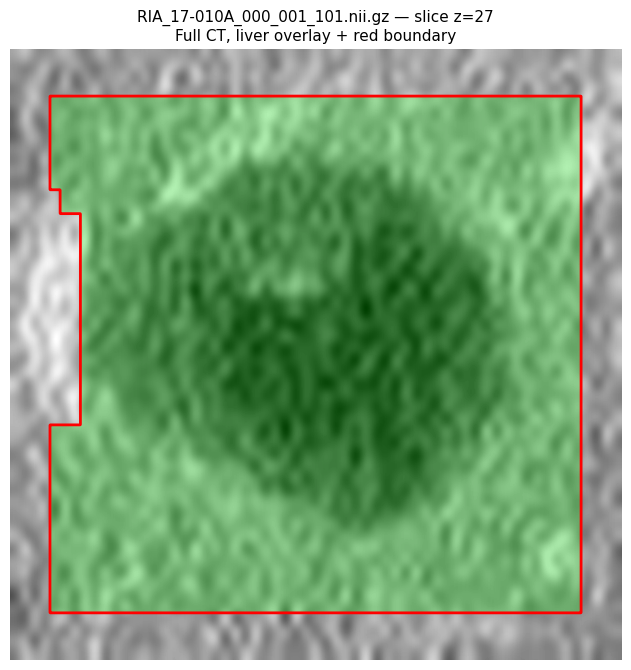

In [5]:
import os
import numpy as np
import nibabel as nib
from scipy.ndimage import label as ndimage_label, binary_fill_holes, binary_closing, binary_opening
from PIL import Image
import matplotlib.pyplot as plt

# =========================
# CONFIG — adjust as needed
# =========================
IMAGE_DIR = "/mnt/largedrive0/rmojtahedi/Kaitlyn_SPIE/KSPIE/updated_data/Image/tumor/ct"
# Tumor labels (expects label==1 for tumor)
TUMOR_LABEL_DIR = "/mnt/largedrive0/rmojtahedi/Kaitlyn_SPIE/KSPIE/updated_data/Image/tumor/final_seg_split"

# OPTION A: liver mask is in the SAME label file (e.g., label==2)
LIVER_LABEL_VALUE = 2         # set to None if not present

# OPTION B: separate directory for liver masks (same filename)
LIVER_MASK_DIR = None         # e.g., "/path/to/liver_masks" if available

WINDOW = (-150, 250)          # HU window for liver-ish contrast
TARGET_SIZE = (1024, 1024)    # match your 2D export
CASE_NAME = None              # e.g., "case_001.nii.gz"; keep None to auto-pick

# =========================
# helpers
# =========================
def standardize_ct_hu(arr, lower=-150, upper=250):
    arr = np.clip(arr, lower, upper).astype(np.float32)
    return (arr - lower) / float(upper - lower)

def load_nifti(path):
    nii = nib.load(path)
    return nii.get_fdata()

def load_volume_pair(image_path, tumor_label_path):
    img = load_nifti(image_path)   # (X, Y, Z)
    lbl_tum = load_nifti(tumor_label_path).astype(np.uint8)
    if img.shape != lbl_tum.shape:
        raise ValueError(f"shape mismatch: {img.shape} vs {lbl_tum.shape}")
    return img, lbl_tum

def largest_component_mask(lbl3d_bool):
    struct = np.ones((3, 3, 3), dtype=np.uint8)
    labeled, n = ndimage_label(lbl3d_bool.astype(np.uint8), structure=struct)
    if n == 0:
        return None, 0
    counts = np.bincount(labeled.ravel())
    counts[0] = 0
    k = np.argmax(counts)
    return (labeled == k), counts[k]

def best_slice_index(mask3d_bool):
    z_areas = [mask3d_bool[:, :, z].sum() for z in range(mask3d_bool.shape[2])]
    z = int(np.argmax(z_areas))
    return z, z_areas[z]

def to_uint8_img(arr01):
    return (np.clip(arr01, 0, 1) * 255.0).astype(np.uint8)

def resize_with_pil(img2d_uint8, size, resample):
    pil = Image.fromarray(img2d_uint8)
    pil = pil.resize(size, resample=resample)
    return np.array(pil)

def pick_case():
    if CASE_NAME is not None:
        return CASE_NAME
    for fname in sorted(os.listdir(IMAGE_DIR)):
        if not fname.endswith(".nii.gz"):
            continue
        img_path = os.path.join(IMAGE_DIR, fname)
        tum_path = os.path.join(TUMOR_LABEL_DIR, fname)
        if not os.path.isfile(tum_path):
            continue
        try:
            _, lbl_tum = load_volume_pair(img_path, tum_path)
            # largest tumor only
            tum3d = (lbl_tum == 1)
            lmask3d, vox = largest_component_mask(tum3d)
            if lmask3d is not None and vox > 0:
                return fname
        except Exception as e:
            print(f"Skipping {fname}: {e}")
            continue
    raise RuntimeError("No case with a tumor found.")

def get_liver_mask_3d(image_path, tumor_label_path, lbl_tum_3d):
    """
    Tries, in order:
      1) same label volume with LIVER_LABEL_VALUE
      2) separate LIVER_MASK_DIR (binary liver mask file with same name)
      3) rough fallback: crude HU-based liver proxy near tumor (slice-wise)
    Returns a boolean 3D mask (liver-ish).
    """
    # try option A: same label file (multi-class)
    if LIVER_LABEL_VALUE is not None:
        try:
            lbl_full = load_nifti(tumor_label_path).astype(np.uint8)
            liver3d = (lbl_full == LIVER_LABEL_VALUE)
            if liver3d.any():
                return liver3d
        except Exception:
            pass

    # try option B: separate liver mask file
    if LIVER_MASK_DIR:
        liver_path = os.path.join(LIVER_MASK_DIR, os.path.basename(image_path))
        if os.path.isfile(liver_path):
            try:
                liver3d = load_nifti(liver_path)
                # binarize if not already
                liver3d = (liver3d > 0).astype(bool)
                if liver3d.any():
                    return liver3d
            except Exception:
                pass

    # Fallback C (very rough): HU + vicinity of tumor to get a proxy
    # This is a weak heuristic; replace with real liver segmentation when available.
    img3d = load_nifti(image_path)
    proxy = np.zeros_like(lbl_tum_3d, dtype=bool)
    # Use slices where tumor appears and expand around HU window typical for liver
    for z in range(img3d.shape[2]):
        if not lbl_tum_3d[:, :, z].any():
            continue
        sl = img3d[:, :, z]
        # HU-ish threshold for parenchyma (broad): [-100, 150]
        mask_hu = (sl >= -100) & (sl <= 150)
        # Focus around abdominal area near tumor: take connected region overlapping tumor dilated neighborhood
        # start from HU mask, keep largest component overlapping tumor vicinity
        comp, n = ndimage_label(mask_hu.astype(np.uint8))
        if n == 0:
            continue
        # pick component with most overlap with tumor slice
        tum = lbl_tum_3d[:, :, z].astype(bool)
        best_lab, best_ov = 0, 0
        for lab_id in range(1, n + 1):
            ov = np.logical_and(comp == lab_id, tum).sum()
            if ov > best_ov:
                best_ov = ov
                best_lab = lab_id
        if best_lab > 0:
            slice_mask = (comp == best_lab)
            # light morph ops
            slice_mask = binary_fill_holes(slice_mask)
            slice_mask = binary_opening(slice_mask, structure=np.ones((5, 5)))
            slice_mask = binary_closing(slice_mask, structure=np.ones((9, 9)))
            proxy[:, :, z] = slice_mask
    # Expand to largest 3D component to remove noise
    prox3d, _ = largest_component_mask(proxy)
    if prox3d is None:
        prox3d = proxy
    return prox3d.astype(bool)

# =========================
# MAIN
# =========================
case = pick_case()
print(f"Visualizing case: {case}")

img_path = os.path.join(IMAGE_DIR, case)
tum_path = os.path.join(TUMOR_LABEL_DIR, case)

img3d, lbl_tum3d = load_volume_pair(img_path, tum_path)
# largest 3D tumor component
tumor3d = (lbl_tum3d == 1)
tumor_largest3d, _ = largest_component_mask(tumor3d)
if tumor_largest3d is None:
    raise RuntimeError(f"No tumor (label==1) in {case}")

# choose slice with max tumor area
z, area = best_slice_index(tumor_largest3d)
print(f"Selected slice z={z} (max tumor area={int(area)} voxels)")

# Get liver mask (from label==LIVER_LABEL_VALUE, separate dir, or fallback)
liver3d = get_liver_mask_3d(img_path, tum_path, tumor_largest3d)
if not liver3d.any():
    raise RuntimeError("Could not obtain a liver mask. Provide a true liver mask or set LIVER_LABEL_VALUE / LIVER_MASK_DIR.")

# Slice data
ct_slice = img3d[:, :, z]
liver_slice = liver3d[:, :, z].astype(np.uint8)

# Window to [0,1] and convert to uint8
ct01 = standardize_ct_hu(ct_slice, lower=WINDOW[0], upper=WINDOW[1])
ct8  = to_uint8_img(ct01)
liver8 = (liver_slice * 255).astype(np.uint8)

# Resize to target (full FOV)
ct8_r    = resize_with_pil(ct8, TARGET_SIZE, resample=Image.LANCZOS)
liver8_r = resize_with_pil(liver8, TARGET_SIZE, resample=Image.NEAREST)

# =========================
# VISUALIZE: CT + liver overlay + red boundary on liver
# =========================
plt.figure(figsize=(6.8, 6.8))
plt.imshow(ct8_r, cmap="gray")
# semi-transparent liver overlay (soft green-ish)
overlay = np.zeros((*liver8_r.shape, 4), dtype=np.float32)
overlay[..., 1] = (liver8_r > 127).astype(np.float32)  # G channel
overlay[..., 3] = 0.25 * (liver8_r > 127).astype(np.float32)  # alpha
plt.imshow(overlay)

# single red contour around liver
plt.contour((liver8_r > 127).astype(float), levels=[0.5], colors="red", linewidths=2.0)

plt.title(f"{case} — slice z={z}\nFull CT, liver overlay + red boundary", fontsize=11)
plt.axis("off")
plt.tight_layout()
# Optional: save figure
# plt.savefig("/mnt/largedrive0/vis_case_liver_boundary.png", dpi=220, bbox_inches="tight")
plt.show()


In [5]:
# ============================================================
# 3-D CT-volume summary ─ tumor voxels = TUMOR_LABEL
# ============================================================
import os, glob, nibabel as nib, numpy as np, pandas as pd
from tqdm import tqdm

# -------- 1. Paths & config --------
image_dir  = "/mnt/largedrive0/rmojtahedi/Kaitlyn_SPIE/KSPIE/updated_data/Image/tumor/ct"
label_dir  = "/mnt/largedrive0/rmojtahedi/Kaitlyn_SPIE/KSPIE/updated_data/Image/tumor/final_seg_split"
output_csv = None          # e.g. "tumor_summary.csv" if you want a file
TUMOR_LABEL = 1            # change if your masks use another value

# -------- 2. Helper to list all NIfTI files --------
def list_nifti(directory):
    paths = glob.glob(os.path.join(directory, "*.nii")) + \
            glob.glob(os.path.join(directory, "*.nii.gz"))
    # key: basename without extension(s) ─ ensures .nii vs .nii.gz match
    return {os.path.splitext(os.path.basename(p))[0].replace(".nii",""): p for p in paths}

images = list_nifti(image_dir)
labels = list_nifti(label_dir)

records, no_lbl = [], []
x_spacings, y_spacings, z_spacings = [], [], []

# -------- 3. Iterate through each image volume --------
for base, img_path in tqdm(images.items(), desc="Processing volumes"):
    if base not in labels:
        no_lbl.append(base)
        continue
    lbl_path = labels[base]

    # --- load volumes ---
    img_nii = nib.load(img_path);  img_data = img_nii.get_fdata()
    lbl_nii = nib.load(lbl_path);  lbl_data = lbl_nii.get_fdata().astype(np.uint8)

    if img_data.shape != lbl_data.shape:
        print(f"[WARN] Dimension mismatch: {base} "
              f"(img {img_data.shape} vs lbl {lbl_data.shape})")
        continue

    spacing = img_nii.header.get_zooms()[:3]          # (x, y, z) in mm
    x_spacings.append(spacing[0]); y_spacings.append(spacing[1]); z_spacings.append(spacing[2])
    voxel_mm3 = np.prod(spacing)

    # --- tumor mask ---
    tumor_mask = lbl_data == TUMOR_LABEL
    n_voxels   = int(tumor_mask.sum())

    tumor_vol_mm3 = n_voxels * voxel_mm3 if n_voxels else np.nan
    tumor_vol_cc  = tumor_vol_mm3 / 1_000 if n_voxels else np.nan
    mean_HU_tumor = np.mean(img_data[tumor_mask])     if n_voxels else np.nan
    std_HU_tumor  = np.std(img_data[tumor_mask])      if n_voxels else np.nan

    records.append({
        "file"              : os.path.basename(img_path),
        "shape (X,Y,Z)"     : img_data.shape,
        "spacing (mm)"      : tuple(np.round(spacing,4)),
        "tumor voxels"      : n_voxels,
        "tumor vol (mm³)"   : tumor_vol_mm3,
        "tumor vol (cc)"    : tumor_vol_cc,
        "mean HU (tumor)"   : mean_HU_tumor,
        "std HU (tumor)"    : std_HU_tumor,
    })

# -------- 4. Assemble DataFrame & compute dataset stats --------
df = pd.DataFrame(records).sort_values("file")
display(df)

# --- tumor-level averages ---
avg_vol_mm3  = df["tumor vol (mm³)"].mean(skipna=True)
avg_vol_cc   = df["tumor vol (cc)"].mean(skipna=True)
avg_HU_tumor = df["mean HU (tumor)"].mean(skipna=True)
avg_std_HU_t = df["std HU (tumor)"].mean(skipna=True)

# --- resolution statistics ---
xy_vals      = x_spacings + y_spacings
xy_min, xy_max = min(xy_vals), max(xy_vals)
xy_mean        = np.mean(xy_vals)

z_min, z_max = min(z_spacings), max(z_spacings)
z_mean       = np.mean(z_spacings)

# --- prettier wording when min == max ---
xy_range = (f"{xy_min:.2f} mm" if xy_min == xy_max
            else f"{xy_min:.2f} mm to {xy_max:.2f} mm")
z_range  = (f"{z_min:.2f} mm"  if z_min == z_max
            else f"{z_min:.2f} mm to {z_max:.2f} mm")

print("\n──────── Dataset-level averages ────────")
print(f"Average tumor volume : {avg_vol_mm3:.0f} mm³ ({avg_vol_cc:.2f} cc)")
print(f"Average tumor HU     : {avg_HU_tumor:.2f}  (σ = {avg_std_HU_t:.2f})")

print(f"\nPre-surgical, contrast-enhanced scans with "
      f"x/y resolution {xy_range} (mean {xy_mean:.2f} mm) and "
      f"z resolution {z_range} (mean {z_mean:.2f} mm).")

# if no_lbl:
#     print(f"\n[INFO] No matching label for {len(no_lbl)} image(s): "
#           f\"{', '.join(sorted(no_lbl))}\")

# if output_csv:
#     df.to_csv(output_csv, index=False)
#     print(f"\nSaved table → {output_csv}")

Processing volumes: 100%|██████████| 1248/1248 [00:09<00:00, 125.70it/s]


,file,"shape (X,Y,Z)",spacing (mm),tumor voxels,tumor vol (mm³),tumor vol (cc),mean HU (tumor),std HU (tumor)
1152,RIA_17-010A_000_001_101.nii.gz,"(52, 61, 55)","(1.0, 1.0, 1.0)",18474,18474.0,18.474,65.684475,23.101404
344,RIA_17-010A_000_002_101.nii.gz,"(85, 82, 79)","(1.0, 1.0, 1.0)",85788,85788.0,85.788,71.580815,16.844384
627,RIA_17-010A_000_003_101.nii.gz,"(43, 44, 42)","(1.0, 1.0, 1.0)",4194,4194.0,4.194,109.076776,14.171351
481,RIA_17-010A_000_004_101.nii.gz,"(50, 51, 55)","(1.0, 1.0, 1.0)",11712,11712.0,11.712,77.661629,19.965925
795,RIA_17-010A_000_005_102.nii.gz,"(46, 46, 45)","(1.0, 1.0, 1.0)",6927,6927.0,6.927,65.380251,18.549714
...,...,...,...,...,...,...,...,...
707,RIA_17-010B_001_1095_5.nii.gz,"(44, 44, 47)","(1.0, 1.0, 1.0)",5630,5630.0,5.630,95.531083,19.647995
609,RIA_17-010B_001_1096_5.nii.gz,"(40, 36, 42)","(1.0, 1.0, 1.0)",2660,2660.0,2.660,86.166165,23.536139
1086,RIA_17-010B_001_1097_5.nii.gz,"(50, 54, 52)","(1.0, 1.0, 1.0)",9215,9215.0,9.215,62.210635,20.665588
1047,RIA_17-010B_001_1099_7.nii.gz,"(38, 37, 40)","(1.0, 1.0, 1.0)",2183,2183.0,2.183,106.090243,34.917934



──────── Dataset-level averages ────────
Average tumor volume : 30369 mm³ (30.37 cc)
Average tumor HU     : 78.59  (σ = 23.90)

Pre-surgical, contrast-enhanced scans with x/y resolution 1.00 mm (mean 1.00 mm) and z resolution 1.00 mm to 7.50 mm (mean 1.09 mm).


## Visualize

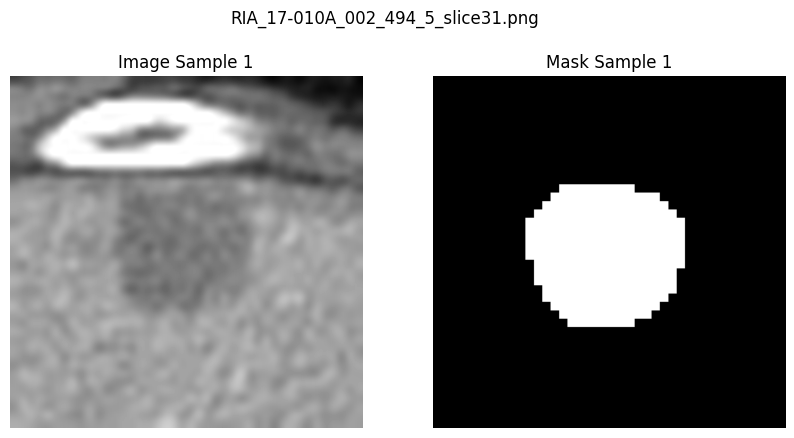

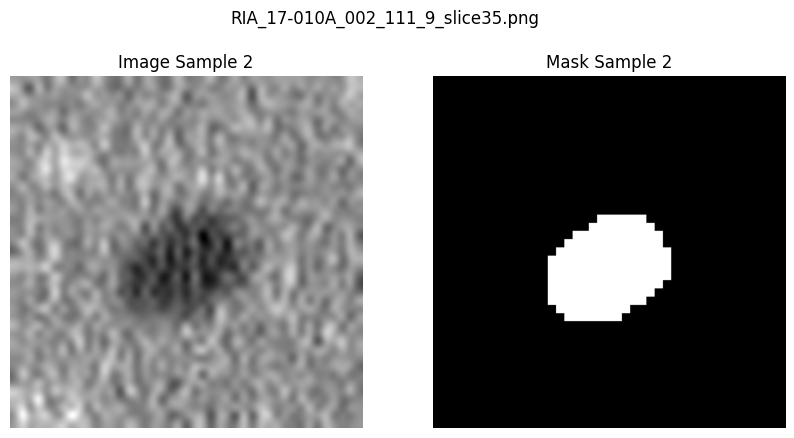

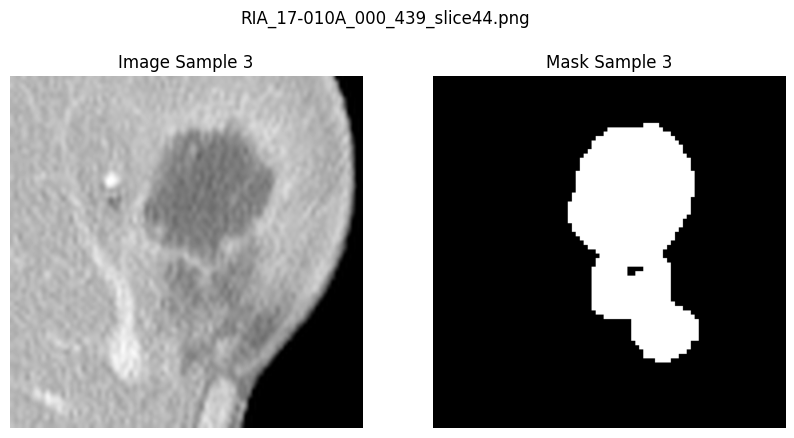

In [2]:
import os
import glob
import random
import matplotlib.pyplot as plt

# Directories for the images and masks (adjust these paths if needed)
images_dir = "/mnt/largedrive0/rmojtahedi/MedSAM/MedSAM2D/data/Tumour/images"
masks_dir = "/mnt/largedrive0/rmojtahedi/MedSAM/MedSAM2D/data/Tumour/masks"

# Get the list of PNG files from the images directory
image_files = sorted(glob.glob(os.path.join(images_dir, "*.png")))

if not image_files:
    print("No PNG slices found in the images directory.")
else:
    # Show up to 3 random samples
    n_to_show = min(3, len(image_files))
    samples = random.sample(image_files, n_to_show)
    
    for i, img_path in enumerate(samples, 1):
        # Build the corresponding mask file path using the same filename
        mask_path = os.path.join(masks_dir, os.path.basename(img_path))
        
        # Load image and mask using matplotlib
        image = plt.imread(img_path)
        mask = plt.imread(mask_path)
        
        # Create a side-by-side plot for the image and mask
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
        
        ax1.imshow(image, cmap='gray')
        ax1.set_title(f"Image Sample {i}")
        ax1.axis('off')
        
        ax2.imshow(mask, cmap='gray')
        ax2.set_title(f"Mask Sample {i}")
        ax2.axis('off')
        
        plt.suptitle(os.path.basename(img_path))
        plt.show()

# --------------------
# Apply Medical-SAM-Adapter to Extracted 2D Images
# --------------------


In [2]:
!PYTHONHASHSEED=42 CUBLAS_WORKSPACE_CONFIG=:4096:8 python train.py \
  -net sam -mod sam_adpt -exp_name Tumor_LoRA_plus \
  --sam_ckpt ./checkpoint/sam/sam_vit_b_01ec64.pth \
  -image_size 1024 -b 2 \
  -dataset liver -data_path /mnt/largedrive1/rmojtahedi/medsam_adapter/data/all_tumor_data \
  -gpu_device 0 \
  -pretrain /home/rmojtahedi/.cache/huggingface/hub/models--KidsWithTokens--Medical-Adapter-Zoo/snapshots/02676e187d5f74ee4ebc3dea24669c552f486e24/Abdominal_Liver_sam_128.pth \
  -epochs 120 -early_stop_threshold 15 \
  --prompt_types single_point,multi_point,bbox_05,bbox_075,none \
  -adapter_type lora \
  -mid_dim 128 \
  -lr 1.5e-4 -weight_decay 0.0 \
  -scheduler cosine -warmup_pct 0.05 \
  -val_freq 1 -save_freq 20 \
  -seed 42 -n_folds 1 -cv_seed 42

[utils] Space‑Adapter retie: fixed 36 / 36 modules → in_dim=768
[freeze] 7.27M trainable / 102.81M total (7.08%)
[adapter:lora] 7.27M trainable / 102.81M total (7.08%)
Epoch 0:   0%|                                        | 0/3032 [00:00<?, ?img/s]/mnt/largedrive1/rmojtahedi/medsam_adapter/models/sam/modeling/prompt_encoder.py:234: UserWarning: cumsum_cuda_kernel does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:83.)
  y_embed = grid.cumsum(dim=0) - 0.5
/mnt/largedrive1/rmojtahedi/medsam_adapter/models/sam/modeling/prompt_encoder.py:235: UserWarning: cumsum_cuda_kernel does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/py

In [1]:
!PYTHONHASHSEED=42 CUBLAS_WORKSPACE_CONFIG=:4096:8 python train.py \
  -net sam -mod sam_adpt -exp_name Tumor_LoRA_r64_ES12 \
  --sam_ckpt ./checkpoint/sam/sam_vit_b_01ec64.pth \
  -image_size 1024 -b 2 \
  -dataset liver -data_path /mnt/largedrive1/rmojtahedi/medsam_adapter/data/all_tumor_data \
  -gpu_device 1 \
  -pretrain "/mnt/largedrive1/rmojtahedi/medsam_adapter/Abdominal_Liver_sam_128.pth" \
  -epochs 120 -early_stop_threshold 10 \
  --prompt_types single_point,multi_point,bbox_05,bbox_075,none \
  -adapter_type lora \
  --target_modules "qkv,proj,fc1,fc2,lin1,lin2,patch_embed.proj" \
  -lr 1.5e-4 -weight_decay 0.01 \
  -scheduler cosine -warmup_pct 0.05 \
  -val_freq 1 -save_freq 20 \
  -seed 42 -n_folds 1 -cv_seed 42

[utils] Space‑Adapter retie: examined 36 modules; no mismatches detected
[freeze] 9.54M trainable / 113.92M total (8.37%)
[adapter:lora] 9.54M trainable / 113.92M total (8.37%)
Epoch 0:   0%|                                        | 0/3032 [00:00<?, ?img/s]/mnt/largedrive1/rmojtahedi/medsam_adapter/models/sam/modeling/prompt_encoder.py:234: UserWarning: cumsum_cuda_kernel does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:83.)
  y_embed = grid.cumsum(dim=0) - 0.5
/mnt/largedrive1/rmojtahedi/medsam_adapter/models/sam/modeling/prompt_encoder.py:235: UserWarning: cumsum_cuda_kernel does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://gith

### Final Test Code

In [1]:
# All-adapter patient-wise evaluation (LoRA, QLoRA, Conv, DiSCo) on physical GPU 1
# - Robust patient-ID extraction with multiple rules; auto-picks the one that yields 90 patients
# - No PEFT required for LoRA/QLoRA; Conv/DiSCo go through utils.get_network
# - Matches training knobs: image_size/out_size, prompt_types, pretrain backbone, BF16 autocast, target_modules
# - OOM-safe fallback & compact logs; rich diagnostics saved to CSV/JSON
import os, sys, json, subprocess, textwrap

# ---- Paths (edit only if your tree is different) ---------------------------------------
BASE_DIR = "/mnt/largedrive1/rmojtahedi/medsam_adapter"
RUN_ROOT = os.path.join(BASE_DIR, "experiments", "Finaal_Run")
TEST_DIR = os.path.join(BASE_DIR, "Test", "all_tumor_data_91")  # contains images/ and masks/
# ----------------------------------------------------------------------------------------

# If you've installed peft+bitsandbytes and want exact QLoRA, set this in your env before running:
#   %env FORCE_PEFT=1
FORCE_PEFT = os.environ.get("FORCE_PEFT", "0") == "1"

# Desired number of patients (your request)
EXPECTED_N_PATIENTS = int(os.environ.get("EXPECTED_N_PATIENTS", "90"))

script_path = os.path.join(BASE_DIR, "_tmp_eval_all_gpu1_patientwise.py")

# NOTE: outer string uses triple *single* quotes so inner docstrings (""") are safe
child = r'''
import os, sys, re, glob, json, math, time, warnings
from datetime import datetime
from typing import Dict, List, Optional, Union, Tuple, Set, Callable

# --------------------------------- Environment -----------------------------------------
# Run on physical GPU 1 and mirror your training env knobs
os.environ["CUDA_VISIBLE_DEVICES"] = "1"   # physical GPU 1 -> process-local cuda:0
os.environ.setdefault("TRANSFORMERS_NO_TORCHVISION","1")
os.environ.setdefault("HF_HUB_DISABLE_TELEMETRY","1")
os.environ.setdefault("HF_NO_FLASH_ATTENTION","1")
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"
os.environ["PYTHONHASHSEED"] = "42"
os.environ["TORCH_DETERMINISTIC"] = "1"
os.environ.setdefault("OMP_NUM_THREADS","1")
os.environ.setdefault("MKL_NUM_THREADS","1")
os.environ.setdefault("NUMEXPR_MAX_THREADS","1")

BASE_DIR = __BASE_DIR__
RUN_ROOT = __RUN_ROOT__
TEST_DIR = __TEST_DIR__
FORCE_PEFT = __FORCE_PEFT__
EXPECTED_N_PATIENTS = int(os.environ.get("EXPECTED_N_PATIENTS", __EXPECTED_N_PATIENTS__))

if BASE_DIR not in sys.path:
    sys.path.insert(0, BASE_DIR)

# Optional PEFT (only if FORCE_PEFT=1 and installed)
HAS_PEFT = False
if FORCE_PEFT:
    try:
        import peft  # noqa
        HAS_PEFT = True
    except Exception:
        HAS_PEFT = False

warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
from torch import amp
import numpy as np
import torchvision.transforms as T
from torch.utils.data import DataLoader, Subset
from tqdm.auto import tqdm

import utils as U
import function
from dataset.liver import Liver

# ------------------------------ Quiet inner tqdm in function.py -------------------------
try:
    class _SilentTQDM:
        def __init__(self, *a, **k): pass
        def __enter__(self): return self
        def __exit__(self, et, ev, tb): return False
        def update(self, n=1): pass
        def close(self): pass
        def set_postfix(self, *a, **k): pass
        def set_description(self, *a, **k): pass
        def __iter__(self): return iter(())
    function.tqdm = _SilentTQDM
except Exception:
    pass

# Ensure function.GPUdevice points to this process' cuda:0 (or CPU)
try:
    function.GPUdevice = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
except Exception:
    pass

def _now(): return datetime.now().strftime("%Y%m%d_%H%M%S")
def _read_json(p):
    try:
        with open(p, "r") as f: return json.load(f)
    except Exception:
        return None

def set_seed(s=42):
    import random
    random.seed(s); np.random.seed(s); torch.manual_seed(s); torch.cuda.manual_seed_all(s)
    torch.use_deterministic_algorithms(True, warn_only=True)

# --------------------------- Patient-ID parsing: multiple rules --------------------------
# We provide several rules and auto-select the one that:
#   (a) yields EXPECTED_N_PATIENTS on the *intersection* of (images ∩ masks), if possible; else
#   (b) yields the largest intersection; tie-break by images count, then masks count.

_VALID_EXT = (".png", ".jpg", ".jpeg", ".tif", ".tiff")

# TRAIN rule (close to your training code; but allow 1–5 z-digits)
# strips the trailing  _{largest|second|all}_z#### .<ext>
_TRAIN_TAIL = re.compile(r'_(largest|second|all)_z\d{1,5}\.(png|jpg|jpeg|tif|tiff)$', re.I)

def _pid_train(fname: str) -> str:
    base = os.path.basename(fname)
    return _TRAIN_TAIL.sub("", base)

# STRIP-LOOP rule: iteratively strip ending tokens in any order
_SUFFIX_RE = re.compile(r'(?:_z\d{1,5}|_(?:slice|s)\d{1,5}|_(?:largest|second|all))$', re.I)
def _pid_striploop(fname: str) -> str:
    stem = os.path.splitext(os.path.basename(fname))[0]
    changed = True
    while changed:
        changed = False
        m = _SUFFIX_RE.search(stem)
        if m:
            stem = stem[:m.start()]
            changed = True
    return stem

# NII-PREFIX rule: everything *before* the last ".nii" (case-insensitive),
# then also drop a trailing _{largest|second|all} and/or _z#### if still present.
def _pid_nii_prefix(fname: str) -> str:
    stem = os.path.splitext(os.path.basename(fname))[0]
    low  = stem.lower()
    j = low.rfind(".nii")
    if j != -1:
        stem = stem[:j]
    # clean potential trailing tokens (rare after cutting at .nii)
    stem = re.sub(r'_(largest|second|all)$', "", stem, flags=re.I)
    stem = re.sub(r'_z\d{1,5}$', "", stem, flags=re.I)
    return stem

# BEFORE-Z rule: capture prefix before the final  (_{largest|second|all})?_z#### block
def _pid_before_z(fname: str) -> str:
    stem = os.path.splitext(os.path.basename(fname))[0]
    m = re.search(r'^(.*?)(?:_(?:largest|second|all))?_z\d{1,5}$', stem, flags=re.I)
    return m.group(1) if m else stem

_PID_RULES: Dict[str, Callable[[str], str]] = {
    "train_tail" : _pid_train,
    "strip_loop" : _pid_striploop,
    "nii_prefix" : _pid_nii_prefix,
    "before_z"   : _pid_before_z,
}

def _list_files(folder: str) -> List[str]:
    if not os.path.isdir(folder):
        return []
    files = []
    for p in os.listdir(folder):
        full = os.path.join(folder, p)
        if os.path.isfile(full):
            ext = os.path.splitext(full)[1].lower()
            if ext in _VALID_EXT:
                files.append(full)
    return sorted(files)

def _ids(files: List[str], fn: Callable[[str], str]) -> Set[str]:
    return { fn(f) for f in files }

def _choose_pid_rule(images_dir: str, masks_dir: str) -> Tuple[str, Dict[str, dict]]:
    imgs = _list_files(images_dir)
    msks = _list_files(masks_dir)
    if not imgs:
        raise FileNotFoundError(f"No image files found under {images_dir}")
    if not msks:
        raise FileNotFoundError(f"No mask files found under {masks_dir}")

    report: Dict[str, dict] = {}
    for name, fn in _PID_RULES.items():
        ids_img  = _ids(imgs, fn)
        ids_msk  = _ids(msks, fn)
        inter    = ids_img & ids_msk
        union    = ids_img | ids_msk
        report[name] = dict(
            imgs=len(ids_img), masks=len(ids_msk),
            inter=len(inter), union=len(union),
            miss_in_masks=sorted((ids_img - ids_msk))[:10],
            miss_in_images=sorted((ids_msk - ids_img))[:10],
        )

    # selection strategy
    # 1) exact EXPECTED_N_PATIENTS on intersection (if any rule reaches it)
    exact = [r for r, s in report.items() if s["inter"] == EXPECTED_N_PATIENTS]
    if exact:
        # tie-break: prefer rule with imgs closest to EXPECTED_N_PATIENTS too
        exact.sort(key=lambda r: (abs(report[r]["imgs"] - EXPECTED_N_PATIENTS),
                                  -report[r]["imgs"],
                                  -report[r]["masks"]))
        return exact[0], report

    # 2) otherwise, pick the one with largest intersection; tie-break as above
    best = sorted(report.keys(),
                  key=lambda r: (report[r]["inter"], report[r]["imgs"], report[r]["masks"]),
                  reverse=True)
    return best[0], report

# -------------------------------- Minimal LoRA wrappers (shape-adaptive) ---------------
class LoRA_Linear(nn.Module):
    def __init__(self, base: nn.Linear, r: int, alpha: int, p: float):
        super().__init__()
        if not isinstance(base, nn.Linear):
            raise TypeError("LoRA_Linear expects nn.Linear")
        self.base = base
        self.r = int(r)
        self.scale = float(alpha) / max(1, r)
        self.drop = nn.Dropout(p)
        base.weight.requires_grad_(False)
        if base.bias is not None: base.bias.requires_grad_(False)
        self.A = nn.Linear(base.in_features, self.r, bias=False, device=base.weight.device, dtype=base.weight.dtype)
        self.B = nn.Linear(self.r, base.out_features, bias=False, device=base.weight.device, dtype=base.weight.dtype)
        nn.init.kaiming_uniform_(self.A.weight, a=math.sqrt(5))
        nn.init.zeros_(self.B.weight)
    def forward(self, x):
        y = self.base(x)
        t = self.drop(self.A(x))
        return y + self.scale * self.B(t)

class LoRA_Conv2d(nn.Module):
    """
    Conv2d LoRA wrapper that can be reshaped at load-time to match checkpoint kernel sizes.
    Starts as 1x1 A/B; loader may rebuild A/B to match saved LoRA kernels (e.g., 16x16).
    """
    def __init__(self, base: nn.Conv2d, r: int, alpha: int, p: float):
        super().__init__()
        if not isinstance(base, nn.Conv2d) or getattr(base, "groups", 1) != 1:
            raise TypeError("LoRA_Conv2d expects nn.Conv2d(groups=1)")
        self.base = base
        self.r = int(r)
        self.scale = float(alpha) / max(1, r)
        self.drop = nn.Dropout2d(p)
        base.weight.requires_grad_(False)
        if base.bias is not None: base.bias.requires_grad_(False)

        # keep base conv geometry for A if we need non-1x1 kernels
        self._base_stride   = base.stride
        self._base_padding  = base.padding
        self._base_dilation = base.dilation

        dev, dt = base.weight.device, base.weight.dtype
        self.A = nn.Conv2d(base.in_channels, self.r, kernel_size=1, bias=False, device=dev, dtype=dt)
        self.B = nn.Conv2d(self.r, base.out_channels, kernel_size=1, bias=False, device=dev, dtype=dt)
        nn.init.kaiming_uniform_(self.A.weight, a=math.sqrt(5))
        nn.init.zeros_(self.B.weight)

    def forward(self, x):
        y = self.base(x)
        t = self.drop(self.A(x))
        return y + self.scale * self.B(t)

def _looks_like_regex(s: str) -> bool:
    return bool(s.strip()) and (s.strip().startswith("(") or "|" in s or "?" in s or ":" in s)

def inject_lora_wrappers(model: nn.Module, targets: Union[str, List[str]], r: int, alpha: int, p: float) -> Dict[str, nn.Module]:
    patt = None
    names = None
    if isinstance(targets, str) and _looks_like_regex(targets):
        patt = re.compile(targets)
    else:
        names = [t.strip() for t in (targets.split(",") if isinstance(targets, str) else targets) if t.strip()]

    wrapped = {}
    def hit(full: str) -> bool:
        if patt is not None:
            return bool(patt.search(full))
        last = full.split(".")[-1]
        if names is None: return False
        if any("." in n for n in names):
            if any(full.endswith(n) for n in names if "." in n):
                return True
        return last in [n for n in names if "." not in n]

    def recurse(mod, prefix=""):
        for name, child in list(mod.named_children()):
            full = f"{prefix}.{name}" if prefix else name
            if hit(full):
                if isinstance(child, nn.Linear):
                    newm = LoRA_Linear(child, r, alpha, p)
                    setattr(mod, name, newm); wrapped[full] = newm
                elif isinstance(child, nn.Conv2d):
                    newm = LoRA_Conv2d(child, r, alpha, p)
                    setattr(mod, name, newm); wrapped[full] = newm
                else:
                    recurse(child, full)
            else:
                recurse(child, full)
    recurse(model)
    return wrapped

def load_lora_weights_from_ckpt(wrapped: Dict[str, nn.Module], sd: dict):
    """
    Map PEFT-style keys to our injected wrappers. Supports both 1x1 and larger-kernel Conv2d LoRA.
    Harmonizes rank r if checkpoint uses a different r.
    """
    keys = list(sd.keys())

    def find_weight_keys(path_tokens: List[str], which: str) -> Optional[str]:
        base = ".".join(path_tokens)
        cand_subs = [
            f".{base}.",
            f".module.{base}.",
            f".base_model.model.{base}.",
            f".model.{base}.",
            f".{'.'.join(path_tokens[-2:])}.",
            f".{path_tokens[-1]}.",
        ]
        for sub in cand_subs:
            matches = [k for k in keys if (sub in k) and (k.endswith(f"lora_{which}.weight") or k.endswith(f"lora_{which}.default.weight"))]
            if matches:
                matches.sort(key=len, reverse=True)
                return matches[0]
        last = path_tokens[-1]
        matches = [k for k in keys if (last in k and f"lora_{which}" in k and k.endswith("weight"))]
        if matches:
            matches.sort(key=len, reverse=True); return matches[0]
        return None

    def _tuple2(x):
        return x if isinstance(x, tuple) else (x, x)

    missed = []
    for path, mod in wrapped.items():
        toks = path.split(".")
        ka = find_weight_keys(toks, "A")
        kb = find_weight_keys(toks, "B")

        try:
            if isinstance(mod, LoRA_Linear):
                if ka is None or kb is None:
                    missed.append(path); continue
                wA = sd[ka]; wB = sd[kb]
                new_r = int(wA.shape[0]) if wA.ndim == 2 else int(wB.shape[1])
                if new_r != mod.r:
                    if mod.r > 0:
                        mod.scale = float(mod.scale) * (float(mod.r) / float(new_r))
                    mod.r = new_r
                    dev, dt = mod.base.weight.device, mod.base.weight.dtype
                    mod.A = nn.Linear(mod.base.in_features, new_r, bias=False, device=dev, dtype=dt)
                    mod.B = nn.Linear(new_r, mod.base.out_features, bias=False, device=dev, dtype=dt)
                if wA.ndim != 2 or wB.ndim != 2:
                    raise RuntimeError(f"Unexpected LoRA Linear shapes for {path}: A {tuple(wA.shape)}, B {tuple(wB.shape)}")
                mod.A.weight.data.copy_(wA.to(mod.A.weight.dtype))
                mod.B.weight.data.copy_(wB.to(mod.B.weight.dtype))

            elif isinstance(mod, LoRA_Conv2d):
                if ka is None and kb is None:
                    missed.append(path); continue
                wA = sd[ka] if ka is not None else None
                wB = sd[kb] if kb is not None else None

                rA = (int(wA.shape[0]) if (wA is not None and wA.ndim in (2,4)) else None)
                rB = (int(wB.shape[1]) if (wB is not None and wB.ndim in (2,4)) else None)
                new_r = rA if rA is not None else (rB if rB is not None else mod.r)
                if new_r != mod.r:
                    if mod.r > 0:
                        mod.scale = float(mod.scale) * (float(mod.r) / float(new_r))
                    mod.r = new_r

                def _ensure_conv(mod_parent: 'LoRA_Conv2d', attr: str, W: torch.Tensor,
                                 stride: Tuple[int,int], padding: Tuple[int,int], dilation: Tuple[int,int]) -> torch.Tensor:
                    cur = getattr(mod_parent, attr)
                    dev, dt = cur.weight.device, cur.weight.dtype
                    if W.ndim == 2:
                        out_c, in_c = int(W.shape[0]), int(W.shape[1])
                        k = (1, 1)
                        W = W.view(out_c, in_c, 1, 1)
                    elif W.ndim == 4:
                        out_c, in_c, kH, kW = int(W.shape[0]), int(W.shape[1]), int(W.shape[2]), int(W.shape[3])
                        k = (kH, kW)
                    else:
                        raise RuntimeError(f"Unexpected LoRA Conv tensor ndim={W.ndim} for {path}.{attr}")

                    need_rebuild = (cur.out_channels != out_c) or (cur.in_channels != in_c) or (tuple(_tuple2(cur.kernel_size)) != k)
                    if need_rebuild:
                        new_conv = nn.Conv2d(in_c, out_c, kernel_size=k, bias=False,
                                             stride=stride, padding=padding, dilation=dilation,
                                             device=dev, dtype=dt)
                        setattr(mod_parent, attr, new_conv)
                    return W

                if wA is not None:
                    if wA.ndim == 4 and (wA.shape[2] != 1 or wA.shape[3] != 1):
                        strideA, padA, dilA = mod._base_stride, mod._base_padding, mod._base_dilation
                    else:
                        strideA, padA, dilA = (1,1), (0,0), (1,1)
                    wA_fixed = _ensure_conv(mod, "A", wA, strideA, padA, dilA)
                    mod.A.weight.data.copy_(wA_fixed.to(mod.A.weight.dtype))
                else:
                    if mod.A.out_channels != new_r or mod.A.in_channels != mod.base.in_channels:
                        dev, dt = mod.base.weight.device, mod.base.weight.dtype
                        mod.A = nn.Conv2d(mod.base.in_channels, new_r, kernel_size=1, bias=False,
                                          stride=1, padding=0, dilation=1, device=dev, dtype=dt)
                        nn.init.kaiming_uniform_(mod.A.weight, a=math.sqrt(5))

                if wB is not None:
                    if wB.ndim == 4 and (wB.shape[2] != 1 or wB.shape[3] != 1):
                        kH, kW = int(wB.shape[2]), int(wB.shape[3])
                        strideB, padB, dilB = (1,1), (kH//2, kW//2), (1,1)
                    else:
                        strideB, padB, dilB = (1,1), (0,0), (1,1)
                    wB_fixed = _ensure_conv(mod, "B", wB, strideB, padB, dilB)
                    mod.B.weight.data.copy_(wB_fixed.to(mod.B.weight.dtype))
                else:
                    if mod.B.in_channels != new_r or mod.B.out_channels != mod.base.out_channels:
                        dev, dt = mod.base.weight.device, mod.base.weight.dtype
                        mod.B = nn.Conv2d(new_r, mod.base.out_channels, kernel_size=1, bias=False,
                                          stride=1, padding=0, dilation=1, device=dev, dtype=dt)
                        nn.init.zeros_(mod.B.weight)
        except Exception as e:
            print(f"[WARN] LoRA load issue at {path}: {e}")
            missed.append(path)

    if missed:
        print(f"[WARN] LoRA weights not found or partially loaded for {len(missed)} modules (first 5): {missed[:5]}")

class _NoWriter:
    def add_scalar(self, *a, **k): return

# --------------------------- Discover latest checkpoints per adapter ---------------------
def find_latest_ckpt(adapter: str) -> Optional[dict]:
    root = os.path.join(RUN_ROOT, adapter)
    if not os.path.isdir(root):
        return None
    cands = []
    for run_dir in [os.path.join(root, d) for d in os.listdir(root) if os.path.isdir(os.path.join(root, d))]:
        if os.path.basename(run_dir).startswith("_"): continue
        for fold_dir in [os.path.join(run_dir, d) for d in os.listdir(run_dir) if d.startswith("fold_")]:
            ckdir = os.path.join(fold_dir, "checkpoints")
            if not os.path.isdir(ckdir): continue
            for ck in glob.glob(os.path.join(ckdir, f"best_{adapter}_fold*.pth")):
                cands.append(dict(
                    adapter=adapter, run_dir=run_dir, fold_dir=fold_dir, ckpt=ck,
                    hparams=os.path.join(fold_dir, "results", "hparams.json"),
                    meta=os.path.join(fold_dir, "results", "meta.json"),
                    mtime=os.path.getmtime(ck),
                ))
    if not cands:
        return None
    cands.sort(key=lambda x: x["mtime"], reverse=True)
    return cands[0]

# ------------------------------ Build args from hparams/meta ----------------------------
def build_args_from_hparams(pick: dict):
    hp = _read_json(pick["hparams"]) or _read_json(pick["meta"]) or {}
    args = U.AttrDict(hp)
    # defaults consistent with your training
    args.net         = str(getattr(args, "net", "sam"))
    args.mod         = str(getattr(args, "mod", "sam_adpt"))
    args.encoder     = str(getattr(args, "encoder", "vit_b"))
    args.image_size  = int(getattr(args, "image_size", 1024))
    args.out_size    = int(getattr(args, "out_size", 256))
    args.seed        = int(getattr(args, "seed", 42))
    args.prompt_types= str(getattr(args, "prompt_types", "single_point,multi_point,bbox_05,bbox_075,none"))
    args.distributed = "none"
    args.total_step  = getattr(args, "total_step", None)
    args.grad_checkpointing = bool(getattr(args, "grad_checkpointing", True))
    args.num_virtual_tokens = int(getattr(args, "num_virtual_tokens", 20) if getattr(args, "num_virtual_tokens", None) is not None else 20)
    # Ensure pretrain backbone is set exactly as training did (critical for LoRA/QLoRA)
    if not getattr(args, "pretrain", None):
        p = os.path.join(BASE_DIR, "checkpoint", "sam", "sam_vit_b_01ec64.pth")
        if os.path.exists(p):
            args.pretrain = p
    # Force compute on local 0
    args.gpu_device = 0
    return args

# ------------------------- Build nets for Conv/DiSCo vs LoRA/QLoRA ----------------------
def build_net_conv_disco(pick, args):
    GPU = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    if pick["adapter"] == "disco":
        os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:512,garbage_collection_threshold:0.9"
    else:
        os.environ.pop("PYTORCH_CUDA_ALLOC_CONF", None)
    net = U.get_network(args, args.net, use_gpu=torch.cuda.is_available(), gpu_device=GPU,
                        distribution="none", steps=args.total_step, num_virtual_tokens=args.num_virtual_tokens)
    net.eval()
    ck = torch.load(pick["ckpt"], map_location=GPU)
    sd = ck.get("state_dict", ck)
    net.load_state_dict(sd, strict=False)
    return net

def build_net_lora_like(pick, args, *, is_qlora: bool):
    """
    PEFT-free inference:
      - Build "full" (no adapter) SAM backbone
      - Load pretrain backbone
      - Inject LoRA wrappers into target modules
      - Load only lora_A/lora_B (shape-adaptive for Conv2d)
    """
    GPU = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    args_full = U.AttrDict(args.to_dict() if hasattr(args, "to_dict") else dict(args))
    args_full.adapter_type = "full"
    net = U.get_network(args_full, args_full.net, use_gpu=False, gpu_device=torch.device("cpu"),
                        distribution="none", steps=args_full.total_step, num_virtual_tokens=args_full.num_virtual_tokens)
    net.eval()

    if getattr(args_full, "pretrain", None) and os.path.exists(args_full.pretrain):
        bk = torch.load(args_full.pretrain, map_location="cpu")
        net.load_state_dict(bk, strict=False)

    net = net.to(GPU).eval()
    torch.cuda.empty_cache()

    tmods = getattr(args, "target_modules", None) or "qkv,proj,fc1,fc2,lin1,lin2,patch_embed.proj"
    if is_qlora:
        r = int(getattr(args, "mid_dim", 12) or 12)
        alpha = int(getattr(args, "lora_alpha", r))
        p = float(getattr(args, "lora_dropout", 0.25))
    else:
        r = int(getattr(args, "mid_dim", 64) or 64)
        alpha = int(getattr(args, "lora_alpha", r))
        p = float(getattr(args, "lora_dropout", 0.05))

    wrapped = inject_lora_wrappers(net, tmods, r, alpha, p)
    if not wrapped:
        print("[WARN] No modules were wrapped for LoRA; check target_modules used in training.")

    ck = torch.load(pick["ckpt"], map_location="cpu")
    sd = ck.get("state_dict", ck)
    load_lora_weights_from_ckpt(wrapped, sd)
    return net

# ----------------------------------- Evaluation -----------------------------------------
def eval_one_prompt(ptype, pmap, ds, args, net):
    writer = _NoWriter()
    GPU = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

    # Try the trained batch size, then back off if OOM
    bs0 = int(getattr(args, "b", 2)); tried = [max(1, bs0)]
    if bs0 > 1:
        h = bs0 // 2
        while h >= 1:
            if h not in tried: tried.append(h)
            h //= 2
    if 1 not in tried: tried.append(1)

    def _one(indices, bs):
        sub = Subset(ds, indices)
        loader = DataLoader(sub, batch_size=bs, shuffle=False, num_workers=4, pin_memory=True)
        with torch.inference_mode():
            if torch.cuda.is_available():
                try: function.GPUdevice = GPU
                except Exception: pass
                with amp.autocast(device_type="cuda", dtype=torch.bfloat16):
                    v_loss, v_metrics = function.validation_sam(args, loader, 0, net, writer,
                                                                prompt_type=ptype, visualize_prediction=False)
            else:
                try: function.GPUdevice = torch.device("cpu")
                except Exception: pass
                v_loss, v_metrics = function.validation_sam(args, loader, 0, net, writer,
                                                            prompt_type=ptype, visualize_prediction=False)
        vals = [float(x) for x in (v_metrics if isinstance(v_metrics, (list,tuple)) else [v_metrics])]
        iou  = float(vals[0]) if len(vals)>=1 else float("nan")
        dice = float(vals[1]) if len(vals)>=2 else float("nan")
        hd95 = float(vals[2]) if len(vals)>=3 else None
        return dict(loss=float(v_loss) if v_loss is not None else None, iou=iou, dice=dice, hd95=hd95)

    per_patient = {}
    total_slices = 0; sum_dice_w=0.0; sum_iou_w=0.0

    for pid in tqdm(sorted(pmap.keys()), desc=f"[{ptype}] patients", leave=False, dynamic_ncols=True):
        idxs = pmap[pid]
        res=None
        for bs in tried:
            try:
                res = _one(idxs, bs); break
            except RuntimeError as e:
                if "out of memory" in str(e).lower():
                    torch.cuda.empty_cache(); time.sleep(0.05); continue
                raise
        if res is None:
            # last-resort CPU fallback
            sub = Subset(ds, idxs)
            loader = DataLoader(sub, batch_size=1, shuffle=False, num_workers=0)
            orig_dev_attr = getattr(function, "GPUdevice", None)
            try:
                if orig_dev_attr is not None:
                    function.GPUdevice = torch.device("cpu")
                net.to("cpu")
                with torch.inference_mode():
                    v_loss, v_metrics = function.validation_sam(args, loader, 0, net, _NoWriter(),
                                                                prompt_type=ptype, visualize_prediction=False)
            finally:
                if torch.cuda.is_available():
                    net.to(GPU)
                    if orig_dev_attr is not None:
                        function.GPUdevice = GPU
            vals = [float(x) for x in (v_metrics if isinstance(v_metrics, (list,tuple)) else [v_metrics])]
            iou  = float(vals[0]) if len(vals)>=1 else float("nan")
            dice = float(vals[1]) if len(vals)>=2 else float("nan")
            hd95 = float(vals[2]) if len(vals)>=3 else None
            res = dict(loss=float(v_loss) if v_loss is not None else None, iou=iou, dice=dice, hd95=hd95)

        per_patient[pid] = dict(dice=res["dice"], iou=res["iou"], hd95=res.get("hd95"), n_slices=len(idxs))
        total_slices += len(idxs)
        if not math.isnan(res["dice"]): sum_dice_w += res["dice"]*len(idxs)
        if not math.isnan(res["iou"]):  sum_iou_w  += res["iou"]*len(idxs)

    dices=[v["dice"] for v in per_patient.values() if not math.isnan(v["dice"])]
    ious =[v["iou"]  for v in per_patient.values() if not math.isnan(v["iou"])]
    macro = dict(dice=(float(np.mean(dices)) if dices else float("nan")),
                 iou =(float(np.mean(ious))  if ious  else float("nan")),
                 hd95=(float(np.mean([v["hd95"] for v in per_patient.values() if v.get("hd95") is not None]))
                       if any(v.get("hd95") is not None for v in per_patient.values()) else None))
    micro = dict(dice=(sum_dice_w/total_slices if total_slices>0 else float("nan")),
                 iou =(sum_iou_w /total_slices if total_slices>0 else float("nan")))
    return per_patient, macro, micro

def evaluate_adapter(adapter: str, global_rows: List[dict]):
    pick = find_latest_ckpt(adapter)
    if not pick:
        print(f"[SKIP] No checkpoint found for {adapter}")
        return
    print(f"\n== Adapter: {adapter} ==")
    print("  run_dir    :", pick["run_dir"])
    print("  fold_dir   :", pick["fold_dir"])
    print("  checkpoint :", pick["ckpt"])
    print("  modified   :", datetime.fromtimestamp(pick["mtime"]).strftime("%Y-%m-%d %H:%M:%S"))

    args = build_args_from_hparams(pick)
    args.gpu_device = 0

    # Device banner
    if torch.cuda.is_available():
        torch.cuda.set_device(0)
        print("Using device = cuda:0 →", torch.cuda.get_device_name(0), "(physical GPU 1)")
        try: function.GPUdevice = torch.device("cuda:0")
        except Exception: pass
    else:
        print("Using CPU")
        try: function.GPUdevice = torch.device("cpu")
        except Exception: pass

    set_seed(int(getattr(args,"seed",42)))

    # Build model by adapter
    if adapter in ("conv","disco"):
        net = build_net_conv_disco(pick, args)
    elif adapter == "lora":
        if FORCE_PEFT and HAS_PEFT:
            net = U.get_network(args, args.net, use_gpu=torch.cuda.is_available(), gpu_device=torch.device("cuda:0"),
                                distribution="none", steps=args.total_step, num_virtual_tokens=args.num_virtual_tokens)
            net.eval()
            ck = torch.load(pick["ckpt"], map_location="cuda:0")
            sd = ck.get("state_dict", ck)
            net.load_state_dict(sd, strict=False)
        else:
            net = build_net_lora_like(pick, args, is_qlora=False)
    elif adapter == "qlora":
        if FORCE_PEFT and HAS_PEFT:
            net = U.get_network(args, args.net, use_gpu=torch.cuda.is_available(), gpu_device=torch.device("cuda:0"),
                                distribution="none", steps=args.total_step, num_virtual_tokens=args.num_virtual_tokens)
            net.eval()
            ck = torch.load(pick["ckpt"], map_location="cuda:0")
            sd = ck.get("state_dict", ck)
            net.load_state_dict(sd, strict=False)
        else:
            net = build_net_lora_like(pick, args, is_qlora=True)
    else:
        print(f"[SKIP] Unsupported adapter {adapter}")
        return

    # ---- Choose patient-ID rule from disk (images & masks) -------------------
    images_dir = os.path.join(TEST_DIR, "images")
    masks_dir  = os.path.join(TEST_DIR, "masks")
    pid_rule_name, diag = _choose_pid_rule(images_dir, masks_dir)
    pid_fn = _PID_RULES[pid_rule_name]

    # Dataset & patient map (transforms mirror training)
    tf_img = T.Compose([T.Resize((args.image_size,args.image_size)), T.ToTensor()])
    tf_msk = T.Compose([T.Resize((args.out_size, args.out_size)),  T.ToTensor()])
    ds = Liver(TEST_DIR, transform=tf_img, transform_msk=tf_msk)

    # Build map with the chosen rule
    pmap: Dict[str, List[int]] = {}
    for i, fn in enumerate(ds.images):
        pid = pid_fn(fn)
        pmap.setdefault(pid, []).append(i)
    patients = sorted(pmap.keys())

    import numpy as _np
    print(f"Test set: {len(ds)} slices | patients={len(patients)} | image_size={args.image_size} | out_size={args.out_size} | median slices/patient={int(_np.median([len(v) for v in pmap.values()]))}")
    # Diagnostics
    print("[patient-id] rule selected:", pid_rule_name)
    print("[patient-id] rule diagnostics (images, masks, inter, union) per rule:")
    for rname, stats in diag.items():
        print(f"  - {rname:11s}: imgs={stats['imgs']:3d} masks={stats['masks']:3d} inter={stats['inter']:3d} union={stats['union']:3d}")

    # Cross-check loader vs disk under selected rule
    img_files = _list_files(images_dir); msk_files = _list_files(masks_dir)
    ids_img_sel = _ids(img_files, pid_fn)
    ids_msk_sel = _ids(msk_files, pid_fn)
    ids_inter   = ids_img_sel & ids_msk_sel
    ids_union   = ids_img_sel | ids_msk_sel
    ids_loader  = set(patients)
    missing_in_loader = sorted(ids_inter - ids_loader)
    extra_in_loader   = sorted(ids_loader - ids_inter)

    print(f"[patient-scan] (selected={pid_rule_name}) imgs={len(ids_img_sel)} | masks={len(ids_msk_sel)} | union={len(ids_union)} | inter={len(ids_inter)} | loader_ids={len(ids_loader)}")
    if missing_in_loader:
        print(f"[patient-scan] Present on disk (images∩masks) but not in loader ({len(missing_in_loader)}): {missing_in_loader[:10]}{' ...' if len(missing_in_loader)>10 else ''}")
    if extra_in_loader:
        print(f"[patient-scan] Present in loader but not in (images∩masks) ({len(extra_in_loader)}): {extra_in_loader[:10]}{' ...' if len(extra_in_loader)>10 else ''}")

    # Save a debug CSV mapping patient->n_slices and diffs
    dbg_dir = os.path.join(pick["fold_dir"], "results")
    os.makedirs(dbg_dir, exist_ok=True)
    dbg_csv = os.path.join(dbg_dir, f"patient_map_debug_{_now()}.csv")
    with open(dbg_csv, "w") as f:
        f.write("patient_id,n_slices,in_images,in_masks,in_intersection,in_loader\n")
        for pid in sorted(ids_union | ids_loader):
            n = len(pmap.get(pid, []))
            f.write(f"{pid},{n},{int(pid in ids_img_sel)},{int(pid in ids_msk_sel)},{int(pid in ids_inter)},{int(pid in ids_loader)}\n")
    print(f"[patient-scan] Debug CSV: {dbg_csv}")

    # ---- Evaluate over prompts ------------------------------------------------
    prompts = [p.strip() for p in str(getattr(args,"prompt_types","single_point,multi_point,bbox_05,bbox_075,none")).split(",") if p.strip()]
    per_prompt = {}
    macro_sum  = {}
    micro_sum  = {}

    for ptype in prompts:
        per_patient, macro, micro = eval_one_prompt(ptype, pmap, ds, args, net)
        per_prompt[ptype] = per_patient
        macro_sum[ptype]  = macro
        micro_sum[ptype]  = micro
        print(f"[{adapter}:{ptype}] macro Dice={macro['dice']:.4f} IoU={macro['iou']:.4f}" + (f" | HD95={macro['hd95']:.2f}" if macro['hd95'] is not None else ""))
        print(f"[{adapter}:{ptype}] micro Dice={micro['dice']:.4f} IoU={micro['iou']:.4f}")
        global_rows.append(dict(
            adapter=adapter, checkpoint=pick["ckpt"], prompt_type=ptype,
            n_patients=len(patients),
            macro_dice=macro["dice"], macro_iou=macro["iou"], macro_hd95=macro["hd95"],
            micro_dice=micro["dice"], micro_iou=micro["iou"]
        ))
        try: torch.cuda.empty_cache()
        except Exception: pass

    # Save per-adapter report
    out_dir = os.path.join(pick["fold_dir"], "results", f"eval_patientwise_on_all_tumor_data_{_now()}")
    os.makedirs(out_dir, exist_ok=True)
    with open(os.path.join(out_dir,"summary.json"),"w") as f:
        json.dump(dict(
            adapter=adapter, checkpoint=pick["ckpt"], dataset="all_tumor_data", data_path=TEST_DIR,
            gpu="cuda:0 (physical 1)" if torch.cuda.is_available() else "cpu",
            image_size=args.image_size, out_size=args.out_size,
            prompt_types=prompts, macro_summary=macro_sum, micro_summary=micro_sum,
            pid_rule_selected=pid_rule_name, pid_rule_report=diag,
            patients_loader=len(ids_loader), patients_imgs=len(ids_img_sel),
            patients_masks=len(ids_msk_sel), patients_intersection=len(ids_inter),
            missing_in_loader=missing_in_loader, extra_in_loader=extra_in_loader,
            debug_csv=dbg_csv
        ), f, indent=2)
    for ptype in prompts:
        with open(os.path.join(out_dir, f"per_patient_{ptype}.csv"), "w") as f:
            f.write("patient_id,n_slices,dice,iou,hd95\n")
            for pid in sorted(per_prompt[ptype].keys()):
                m = per_prompt[ptype][pid]
                f.write(f"{pid},{m['n_slices']},{m['dice']},{m['iou']},{m.get('hd95')}\n")
    with open(os.path.join(out_dir, "overall.csv"), "w") as f:
        f.write("prompt_type,macro_dice,macro_iou,macro_hd95,micro_dice,micro_iou\n")
        for ptype in prompts:
            ms = macro_sum[ptype]; mi = micro_sum[ptype]
            f.write(f"{ptype},{ms['dice']},{ms['iou']},{ms.get('hd95')},{mi['dice']},{mi['iou']}\n")

def main():
    # Basic checks
    if not (os.path.exists(os.path.join(TEST_DIR,"images")) and os.path.exists(os.path.join(TEST_DIR,"masks"))):
        raise FileNotFoundError(f"Test dir missing images/ or masks/: {TEST_DIR}")

    adapters = ["lora","qlora","conv","disco"]  # add "rosa" later if needed
    global_rows=[]
    ran=False
    print("Launching ALL‑adapter patient‑wise evaluation on physical GPU 1 …")
    for a in adapters:
        evaluate_adapter(a, global_rows); ran=True
    if not ran:
        raise RuntimeError("No adapters evaluated.")

    # Aggregate summary
    agg_dir = os.path.join(RUN_ROOT, "_aggregates_latest")
    os.makedirs(agg_dir, exist_ok=True)
    stamp=_now()
    csv_path=os.path.join(agg_dir, f"summary_all_adapters_{stamp}.csv")
    js_path =os.path.join(agg_dir, f"summary_all_adapters_{stamp}.json")
    with open(csv_path,"w") as f:
        f.write("adapter,checkpoint,prompt_type,n_patients,macro_dice,macro_iou,macro_hd95,micro_dice,micro_iou\n")
        for r in global_rows:
            f.write(f"{r['adapter']},{r['checkpoint']},{r['prompt_type']},{r['n_patients']},{r['macro_dice']},{r['macro_iou']},{r.get('macro_hd95')},{r['micro_dice']},{r['micro_iou']}\n")
    with open(js_path,"w") as f:
        json.dump(dict(rows=global_rows), f, indent=2)
    print("\n==== Aggregate summary saved ====")
    print("CSV :", csv_path)
    print("JSON:", js_path)

if __name__=="__main__":
    main()
'''

# Fill placeholders safely
filled = (
    child
    .replace("__BASE_DIR__", json.dumps(BASE_DIR))
    .replace("__RUN_ROOT__", json.dumps(RUN_ROOT))
    .replace("__TEST_DIR__", json.dumps(TEST_DIR))
    .replace("__FORCE_PEFT__", "True" if FORCE_PEFT else "False")
    .replace("__EXPECTED_N_PATIENTS__", str(EXPECTED_N_PATIENTS))
)

with open(script_path, "w") as f:
    f.write(textwrap.dedent(filled))

# Launch (child sees physical GPU 1 as cuda:0)
env = os.environ.copy()
env["CUDA_VISIBLE_DEVICES"] = "1"  # physical GPU index -> process-local cuda:0
proc = subprocess.run([sys.executable, script_path], cwd=BASE_DIR, env=env)
if proc.returncode != 0:
    raise RuntimeError("Subprocess evaluation failed — check the printed logs above for the exact line.")

[launcher] Child script written to: /tmp/_tmp_eval_gpu2_bvaeedt9.py
Launching LoRA/QLoRA patient‑wise evaluation on physical GPU 2 …

== Dataset: all_tumor_data | Adapter: lora ==
  data_path : /mnt/largedrive1/rmojtahedi/medsam_adapter/Test/all_tumor_data_91
[patient-id] rule selected: train_tail
 - train_tail : imgs= 91 masks= 91 inter= 91 union= 91
 - strip_loop : imgs= 91 masks= 91 inter= 91 union= 91
 - nii_prefix : imgs= 91 masks= 91 inter= 91 union= 91
 - before_z   : imgs= 91 masks= 91 inter= 91 union= 91
[patient-scan] imgs=91 | masks=91 | union=91 | inter=91
[patient-scan] Debug CSV: /mnt/largedrive1/rmojtahedi/medsam_adapter/experiments/Finaal_Run/lora/Tumor_LoRA_r64_ES12_all_tumor_data_2025-09-07_15-06-07.943670/fold_00/results/all_tumor_data__patient_map_debug_20251024_205638.csv
Using device = cuda:0 → NVIDIA A100-PCIE-40GB (physical GPU 2)
[utils] Space‑Adapter retie: examined 36 modules; no mismatches detected
[attach_adapter] Using FULL fine‑tuning (no adapter).
[param

[multi_point] patients:   1%|          | 1/91 [00:00<00:16,  5.40it/s]  

[all_tumor_data | lora:single_point] macro Dice=0.7218 IoU=0.6359 | HD95=55.81
[all_tumor_data | lora:single_point] micro Dice=0.7218 IoU=0.6359


[bbox_05] patients:   0%|          | 0/91 [00:00<?, ?it/s]             

[all_tumor_data | lora:multi_point] macro Dice=0.7094 IoU=0.6230 | HD95=58.15
[all_tumor_data | lora:multi_point] micro Dice=0.7094 IoU=0.6230


[bbox_075] patients:   1%|          | 1/91 [00:00<00:15,  5.76it/s]

[all_tumor_data | lora:bbox_05] macro Dice=0.6743 IoU=0.5800 | HD95=58.01
[all_tumor_data | lora:bbox_05] micro Dice=0.6743 IoU=0.5800


[none] patients:   0%|          | 0/91 [00:00<?, ?it/s]             

[all_tumor_data | lora:bbox_075] macro Dice=0.6758 IoU=0.5794 | HD95=59.08
[all_tumor_data | lora:bbox_075] micro Dice=0.6758 IoU=0.5794


[all_tumor_data | lora:none] macro Dice=0.7447 IoU=0.6537 | HD95=57.88
[all_tumor_data | lora:none] micro Dice=0.7447 IoU=0.6537

== Dataset: all_tumor_data | Adapter: qlora ==
  data_path : /mnt/largedrive1/rmojtahedi/medsam_adapter/Test/all_tumor_data_91
[patient-id] rule selected: train_tail
 - train_tail : imgs= 91 masks= 91 inter= 91 union= 91
 - strip_loop : imgs= 91 masks= 91 inter= 91 union= 91
 - nii_prefix : imgs= 91 masks= 91 inter= 91 union= 91
 - before_z   : imgs= 91 masks= 91 inter= 91 union= 91
[patient-scan] imgs=91 | masks=91 | union=91 | inter=91
[patient-scan] Debug CSV: /mnt/largedrive1/rmojtahedi/medsam_adapter/experiments/Finaal_Run/qlora/Tumor_QLoRA_r12_FP4_ES12_all_tumor_data_2025-09-03_15-42-35.099826/fold_00/results/all_tumor_data__patient_map_debug_20251024_205814.csv
Using device = cuda:0 → NVIDIA A100-PCIE-40GB (physical GPU 2)
[utils] Space‑Adapter retie: fixed 36 / 36 modules → in_dim=768
[attach_adapter] Using FULL fine‑tuning (no adapter).
[params] 93.

[multi_point] patients:   1%|          | 1/91 [00:00<00:16,  5.57it/s]  

[all_tumor_data | qlora:single_point] macro Dice=0.6780 IoU=0.5960 | HD95=61.03
[all_tumor_data | qlora:single_point] micro Dice=0.6780 IoU=0.5960


[bbox_05] patients:   0%|          | 0/91 [00:00<?, ?it/s]             

[all_tumor_data | qlora:multi_point] macro Dice=0.6703 IoU=0.5874 | HD95=60.60
[all_tumor_data | qlora:multi_point] micro Dice=0.6703 IoU=0.5874


[bbox_075] patients:   1%|          | 1/91 [00:00<00:15,  5.98it/s]

[all_tumor_data | qlora:bbox_05] macro Dice=0.6019 IoU=0.5081 | HD95=63.87
[all_tumor_data | qlora:bbox_05] micro Dice=0.6019 IoU=0.5081


[none] patients:   0%|          | 0/91 [00:00<?, ?it/s]             

[all_tumor_data | qlora:bbox_075] macro Dice=0.5886 IoU=0.4935 | HD95=70.51
[all_tumor_data | qlora:bbox_075] micro Dice=0.5886 IoU=0.4935


[all_tumor_data | qlora:none] macro Dice=0.6950 IoU=0.6107 | HD95=46.30
[all_tumor_data | qlora:none] micro Dice=0.6950 IoU=0.6107

== Dataset: largest_tumor_data | Adapter: lora ==
  data_path : /mnt/largedrive1/rmojtahedi/medsam_adapter/Test/largest_tumor_data_91
[patient-id] rule selected: train_tail
 - train_tail : imgs= 91 masks= 91 inter= 91 union= 91
 - strip_loop : imgs= 91 masks= 91 inter= 91 union= 91
 - nii_prefix : imgs= 91 masks= 91 inter= 91 union= 91
 - before_z   : imgs= 91 masks= 91 inter= 91 union= 91
[patient-scan] imgs=91 | masks=91 | union=91 | inter=91
[patient-scan] Debug CSV: /mnt/largedrive1/rmojtahedi/medsam_adapter/experiments/Finaal_Run/lora/Tumor_LoRA_r64_ES12_all_tumor_data_2025-09-07_15-06-07.943670/fold_00/results/largest_tumor_data__patient_map_debug_20251024_205951.csv
Using device = cuda:0 → NVIDIA A100-PCIE-40GB (physical GPU 2)
[utils] Space‑Adapter retie: examined 36 modules; no mismatches detected
[attach_adapter] Using FULL fine‑tuning (no adapte

[multi_point] patients:   1%|          | 1/91 [00:00<00:16,  5.37it/s]  

[largest_tumor_data | lora:single_point] macro Dice=0.6814 IoU=0.5808 | HD95=88.35
[largest_tumor_data | lora:single_point] micro Dice=0.6814 IoU=0.5808


[bbox_05] patients:   1%|          | 1/91 [00:00<00:15,  5.65it/s]     

[largest_tumor_data | lora:multi_point] macro Dice=0.6595 IoU=0.5596 | HD95=91.73
[largest_tumor_data | lora:multi_point] micro Dice=0.6595 IoU=0.5596


[bbox_075] patients:   0%|          | 0/91 [00:00<?, ?it/s]        

[largest_tumor_data | lora:bbox_05] macro Dice=0.6286 IoU=0.5215 | HD95=88.56
[largest_tumor_data | lora:bbox_05] micro Dice=0.6286 IoU=0.5215


[none] patients:   1%|          | 1/91 [00:00<00:15,  5.64it/s]     

[largest_tumor_data | lora:bbox_075] macro Dice=0.6376 IoU=0.5321 | HD95=88.10
[largest_tumor_data | lora:bbox_075] micro Dice=0.6376 IoU=0.5321


[largest_tumor_data | lora:none] macro Dice=0.7032 IoU=0.5987 | HD95=90.07
[largest_tumor_data | lora:none] micro Dice=0.7032 IoU=0.5987

== Dataset: largest_tumor_data | Adapter: qlora ==
  data_path : /mnt/largedrive1/rmojtahedi/medsam_adapter/Test/largest_tumor_data_91
[patient-id] rule selected: train_tail
 - train_tail : imgs= 91 masks= 91 inter= 91 union= 91
 - strip_loop : imgs= 91 masks= 91 inter= 91 union= 91
 - nii_prefix : imgs= 91 masks= 91 inter= 91 union= 91
 - before_z   : imgs= 91 masks= 91 inter= 91 union= 91
[patient-scan] imgs=91 | masks=91 | union=91 | inter=91
[patient-scan] Debug CSV: /mnt/largedrive1/rmojtahedi/medsam_adapter/experiments/Finaal_Run/qlora/Tumor_QLoRA_r12_FP4_ES12_all_tumor_data_2025-09-03_15-42-35.099826/fold_00/results/largest_tumor_data__patient_map_debug_20251024_210132.csv
Using device = cuda:0 → NVIDIA A100-PCIE-40GB (physical GPU 2)
[utils] Space‑Adapter retie: fixed 36 / 36 modules → in_dim=768
[attach_adapter] Using FULL fine‑tuning (no ad

[multi_point] patients:   1%|          | 1/91 [00:00<00:17,  5.13it/s]  

[largest_tumor_data | qlora:single_point] macro Dice=0.6360 IoU=0.5437 | HD95=91.96
[largest_tumor_data | qlora:single_point] micro Dice=0.6360 IoU=0.5437


[bbox_05] patients:   1%|          | 1/91 [00:00<00:15,  5.75it/s]     

[largest_tumor_data | qlora:multi_point] macro Dice=0.6252 IoU=0.5353 | HD95=93.43
[largest_tumor_data | qlora:multi_point] micro Dice=0.6252 IoU=0.5353


[bbox_075] patients:   1%|          | 1/91 [00:00<00:15,  5.86it/s]

[largest_tumor_data | qlora:bbox_05] macro Dice=0.5935 IoU=0.4989 | HD95=88.28
[largest_tumor_data | qlora:bbox_05] micro Dice=0.5935 IoU=0.4989


[none] patients:   0%|          | 0/91 [00:00<?, ?it/s]             

[largest_tumor_data | qlora:bbox_075] macro Dice=0.5820 IoU=0.4891 | HD95=93.31
[largest_tumor_data | qlora:bbox_075] micro Dice=0.5820 IoU=0.4891


[largest_tumor_data | qlora:none] macro Dice=0.6573 IoU=0.5630 | HD95=75.18
[largest_tumor_data | qlora:none] micro Dice=0.6573 IoU=0.5630
Aggregate CSV: /mnt/largedrive1/rmojtahedi/medsam_adapter/experiments/Finaal_Run/_aggregates_latest/summary_lora_qlora_20251024_210321.csv


In [2]:
# All-adapter patient-wise evaluation (RoSA, Conv, LoRA, QLoRA, DiSCo) on physical GPU 1
# - Uses a writable temp dir for the child script (fixes PermissionError)
# - Runs BOTH datasets: all_tumor_data_91 and largest_tumor_data_91
# - Robust patient-ID rules; OOM-safe; BF16 autocast; LoRA/QLoRA PEFT-free unless FORCE_PEFT=1
# - Saves per-dataset + combined aggregates; prints nice summary tables to stdout
import os, sys, json, subprocess, textwrap, tempfile

# ---- Paths (edit only if your tree is different) ---------------------------------------
BASE_DIR = "/mnt/largedrive1/rmojtahedi/medsam_adapter"
RUN_ROOT = os.path.join(BASE_DIR, "experiments", "Finaal_Run")

# Datasets to evaluate (you asked for both all tumors and largest tumors)
DATASETS = [
    {
        "label": "all_tumor_data_91",
        "path": os.path.join(BASE_DIR, "Test", "all_tumor_data_91"),
        "expected_n": int(os.environ.get("EXPECTED_N_PATIENTS", "90")),
    },
    {
        "label": "largest_tumor_data_91",
        "path": "/mnt/largedrive1/rmojtahedi/medsam_adapter/Test/largest_tumor_data_91",
        "expected_n": int(os.environ.get("EXPECTED_N_PATIENTS", "90")),
    },
]
# ----------------------------------------------------------------------------------------

# If you've installed peft+bitsandbytes and want exact QLoRA, set this in your env before running:
#   %env FORCE_PEFT=1
FORCE_PEFT = os.environ.get("FORCE_PEFT", "0") == "1"

# We'll place the child script in a guaranteed-writable temp directory (avoids PermissionError)
_tmp_root = tempfile.mkdtemp(prefix="medsam_eval_")
script_path = os.path.join(_tmp_root, "_tmp_eval_all_gpu1_patientwise_bothsets.py")

# NOTE: outer string uses triple *single* quotes so inner docstrings (""") are safe
child = r'''
import os, sys, re, glob, json, math, time, warnings
from datetime import datetime
from typing import Dict, List, Optional, Union, Tuple, Set, Callable

# --------------------------------- Environment -----------------------------------------
# Run on physical GPU 1 and mirror your training env knobs
os.environ["CUDA_VISIBLE_DEVICES"] = "1"   # physical GPU 1 -> process-local cuda:0
os.environ.setdefault("TRANSFORMERS_NO_TORCHVISION","1")
os.environ.setdefault("HF_HUB_DISABLE_TELEMETRY","1")
os.environ.setdefault("HF_NO_FLASH_ATTENTION","1")
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"
os.environ["PYTHONHASHSEED"] = "42"
os.environ["TORCH_DETERMINISTIC"] = "1"
os.environ.setdefault("OMP_NUM_THREADS","1")
os.environ.setdefault("MKL_NUM_THREADS","1")
os.environ.setdefault("NUMEXPR_MAX_THREADS","1")

BASE_DIR = __BASE_DIR__
RUN_ROOT = __RUN_ROOT__
FORCE_PEFT = __FORCE_PEFT__
DATASETS = __DATASETS__  # [{'label':..., 'path':..., 'expected_n':...}, ...]

if BASE_DIR not in sys.path:
    sys.path.insert(0, BASE_DIR)

# Optional PEFT (only if FORCE_PEFT=1 and installed)
HAS_PEFT = False
if FORCE_PEFT:
    try:
        import peft  # noqa
        HAS_PEFT = True
    except Exception:
        HAS_PEFT = False

warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
from torch import amp
import numpy as np
import torchvision.transforms as T
from torch.utils.data import DataLoader, Subset
from tqdm.auto import tqdm

import utils as U
import function
from dataset.liver import Liver

# ------------------------------ Quiet inner tqdm in function.py -------------------------
try:
    class _SilentTQDM:
        def __init__(self, *a, **k): pass
        def __enter__(self): return self
        def __exit__(self, et, ev, tb): return False
        def update(self, n=1): pass
        def close(self): pass
        def set_postfix(self, *a, **k): pass
        def set_description(self, *a, **k): pass
        def __iter__(self): return iter(())
    function.tqdm = _SilentTQDM
except Exception:
    pass

# Ensure function.GPUdevice points to this process' cuda:0 (or CPU)
try:
    function.GPUdevice = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
except Exception:
    pass

def _now(): return datetime.now().strftime("%Y%m%d_%H%M%S")
def _read_json(p):
    try:
        with open(p, "r") as f: return json.load(f)
    except Exception:
        return None

def set_seed(s=42):
    import random
    random.seed(s); np.random.seed(s); torch.manual_seed(s); torch.cuda.manual_seed_all(s)
    torch.use_deterministic_algorithms(True, warn_only=True)

# --------------------------- Patient-ID parsing: multiple rules --------------------------
_VALID_EXT = (".png", ".jpg", ".jpeg", ".tif", ".tiff")
_TRAIN_TAIL = re.compile(r'_(largest|second|all)_z\d{1,5}\.(png|jpg|jpeg|tif|tiff)$', re.I)

def _pid_train(fname: str) -> str:
    base = os.path.basename(fname)
    return _TRAIN_TAIL.sub("", base)

_SUFFIX_RE = re.compile(r'(?:_z\d{1,5}|_(?:slice|s)\d{1,5}|_(?:largest|second|all))$', re.I)
def _pid_striploop(fname: str) -> str:
    stem = os.path.splitext(os.path.basename(fname))[0]
    changed = True
    while changed:
        changed = False
        m = _SUFFIX_RE.search(stem)
        if m:
            stem = stem[:m.start()]
            changed = True
    return stem

def _pid_nii_prefix(fname: str) -> str:
    stem = os.path.splitext(os.path.basename(fname))[0]
    low  = stem.lower()
    j = low.rfind(".nii")
    if j != -1:
        stem = stem[:j]
    stem = re.sub(r'_(largest|second|all)$', "", stem, flags=re.I)
    stem = re.sub(r'_z\d{1,5}$', "", stem, flags=re.I)
    return stem

def _pid_before_z(fname: str) -> str:
    stem = os.path.splitext(os.path.basename(fname))[0]
    m = re.search(r'^(.*?)(?:_(?:largest|second|all))?_z\d{1,5}$', stem, flags=re.I)
    return m.group(1) if m else stem

_PID_RULES: Dict[str, Callable[[str], str]] = {
    "train_tail" : _pid_train,
    "strip_loop" : _pid_striploop,
    "nii_prefix" : _pid_nii_prefix,
    "before_z"   : _pid_before_z,
}

def _list_files(folder: str) -> List[str]:
    if not os.path.isdir(folder): return []
    files = []
    for p in os.listdir(folder):
        full = os.path.join(folder, p)
        if os.path.isfile(full) and os.path.splitext(full)[1].lower() in _VALID_EXT:
            files.append(full)
    return sorted(files)

def _ids(files: List[str], fn: Callable[[str], str]) -> Set[str]:
    return { fn(f) for f in files }

def _choose_pid_rule(images_dir: str, masks_dir: str, expected_n_patients: int):
    imgs = _list_files(images_dir); msks = _list_files(masks_dir)
    if not imgs: raise FileNotFoundError(f"No image files found under {images_dir}")
    if not msks: raise FileNotFoundError(f"No mask files found under {masks_dir}")

    report = {}
    for name, fn in _PID_RULES.items():
        ids_img = _ids(imgs, fn); ids_msk = _ids(msks, fn)
        inter   = ids_img & ids_msk; union = ids_img | ids_msk
        report[name] = dict(imgs=len(ids_img), masks=len(ids_msk), inter=len(inter), union=len(union),
                            miss_in_masks=sorted((ids_img-ids_msk))[:10], miss_in_images=sorted((ids_msk-ids_img))[:10])
    exact = [r for r,s in report.items() if s["inter"] == expected_n_patients]
    if exact:
        exact.sort(key=lambda r: (abs(report[r]["imgs"]-expected_n_patients), -report[r]["imgs"], -report[r]["masks"]))
        return exact[0], report
    best = sorted(report.keys(), key=lambda r: (report[r]["inter"], report[r]["imgs"], report[r]["masks"]), reverse=True)
    return best[0], report

# -------------------------------- Minimal LoRA wrappers ---------------------------------
class LoRA_Linear(nn.Module):
    def __init__(self, base: nn.Linear, r: int, alpha: int, p: float):
        super().__init__()
        if not isinstance(base, nn.Linear): raise TypeError("LoRA_Linear expects nn.Linear")
        self.base = base; self.r = int(r); self.scale = float(alpha)/max(1,r); self.drop = nn.Dropout(p)
        base.weight.requires_grad_(False); 
        if base.bias is not None: base.bias.requires_grad_(False)
        self.A = nn.Linear(base.in_features, self.r, bias=False, device=base.weight.device, dtype=base.weight.dtype)
        self.B = nn.Linear(self.r, base.out_features, bias=False, device=base.weight.device, dtype=base.weight.dtype)
        nn.init.kaiming_uniform_(self.A.weight, a=math.sqrt(5)); nn.init.zeros_(self.B.weight)
    def forward(self, x):
        y = self.base(x); t = self.drop(self.A(x)); return y + self.scale * self.B(t)

class LoRA_Conv2d(nn.Module):
    def __init__(self, base: nn.Conv2d, r: int, alpha: int, p: float):
        super().__init__()
        if not isinstance(base, nn.Conv2d) or getattr(base,"groups",1)!=1: raise TypeError("LoRA_Conv2d expects nn.Conv2d(groups=1)")
        self.base = base; self.r = int(r); self.scale = float(alpha)/max(1,r); self.drop = nn.Dropout2d(p)
        base.weight.requires_grad_(False); 
        if base.bias is not None: base.bias.requires_grad_(False)
        self._base_stride, self._base_padding, self._base_dilation = base.stride, base.padding, base.dilation
        dev, dt = base.weight.device, base.weight.dtype
        self.A = nn.Conv2d(base.in_channels, self.r, 1, bias=False, device=dev, dtype=dt)
        self.B = nn.Conv2d(self.r, base.out_channels, 1, bias=False, device=dev, dtype=dt)
        nn.init.kaiming_uniform_(self.A.weight, a=math.sqrt(5)); nn.init.zeros_(self.B.weight)
    def forward(self, x):
        y = self.base(x); t = self.drop(self.A(x)); return y + self.scale * self.B(t)

def _looks_like_regex(s: str) -> bool:
    return bool(s.strip()) and (s.strip().startswith("(") or "|" in s or "?" in s or ":" in s)

def inject_lora_wrappers(model: nn.Module, targets: Union[str, List[str]], r: int, alpha: int, p: float) -> Dict[str, nn.Module]:
    patt=None; names=None
    if isinstance(targets,str) and _looks_like_regex(targets): patt = re.compile(targets)
    else: names=[t.strip() for t in (targets.split(",") if isinstance(targets,str) else targets) if t.strip()]
    wrapped={}
    def hit(full:str)->bool:
        if patt is not None: return bool(patt.search(full))
        last = full.split(".")[-1]
        if names is None: return False
        if any("." in n for n in names):
            if any(full.endswith(n) for n in names if "." in n): return True
        return last in [n for n in names if "." not in n]
    def recurse(mod, prefix=""):
        for name, child in list(mod.named_children()):
            full = f"{prefix}.{name}" if prefix else name
            if hit(full):
                if isinstance(child, nn.Linear):
                    newm = LoRA_Linear(child, r, alpha, p); setattr(mod, name, newm); wrapped[full]=newm
                elif isinstance(child, nn.Conv2d):
                    newm = LoRA_Conv2d(child, r, alpha, p); setattr(mod, name, newm); wrapped[full]=newm
                else: recurse(child, full)
            else: recurse(child, full)
    recurse(model); return wrapped

def load_lora_weights_from_ckpt(wrapped: Dict[str, nn.Module], sd: dict):
    keys=list(sd.keys())
    def find_weight_keys(path_tokens: List[str], which: str)->Optional[str]:
        base=".".join(path_tokens)
        cand_subs=[f".{base}.",f".module.{base}.",f".base_model.model.{base}.",f".model.{base}.",f".{'.'.join(path_tokens[-2:])}.",f".{path_tokens[-1]}."]
        for sub in cand_subs:
            matches=[k for k in keys if (sub in k) and (k.endswith(f"lora_{which}.weight") or k.endswith(f"lora_{which}.default.weight"))]
            if matches: matches.sort(key=len, reverse=True); return matches[0]
        last=path_tokens[-1]
        matches=[k for k in keys if (last in k and f"lora_{which}" in k and k.endswith("weight"))]
        if matches: matches.sort(key=len, reverse=True); return matches[0]
        return None
    def _tuple2(x): return x if isinstance(x,tuple) else (x,x)
    missed=[]
    for path, mod in wrapped.items():
        toks=path.split("."); ka=find_weight_keys(toks,"A"); kb=find_weight_keys(toks,"B")
        try:
            if isinstance(mod, LoRA_Linear):
                if ka is None or kb is None: missed.append(path); continue
                wA=sd[ka]; wB=sd[kb]
                new_r = int(wA.shape[0]) if wA.ndim==2 else int(wB.shape[1])
                if new_r != mod.r:
                    if mod.r>0: mod.scale=float(mod.scale)* (float(mod.r)/float(new_r))
                    mod.r=new_r
                    dev,dt=mod.base.weight.device, mod.base.weight.dtype
                    mod.A = nn.Linear(mod.base.in_features, new_r, bias=False, device=dev, dtype=dt)
                    mod.B = nn.Linear(new_r, mod.base.out_features, bias=False, device=dev, dtype=dt)
                if wA.ndim!=2 or wB.ndim!=2: raise RuntimeError(f"Unexpected LoRA Linear shapes for {path}: A {tuple(wA.shape)}, B {tuple(wB.shape)}")
                mod.A.weight.data.copy_(wA.to(mod.A.weight.dtype)); mod.B.weight.data.copy_(wB.to(mod.B.weight.dtype))
            elif isinstance(mod, LoRA_Conv2d):
                if ka is None and kb is None: missed.append(path); continue
                wA = sd[ka] if ka is not None else None; wB = sd[kb] if kb is not None else None
                rA = (int(wA.shape[0]) if (wA is not None and wA.ndim in (2,4)) else None)
                rB = (int(wB.shape[1]) if (wB is not None and wB.ndim in (2,4)) else None)
                new_r = rA if rA is not None else (rB if rB is not None else mod.r)
                if new_r != mod.r:
                    if mod.r>0: mod.scale=float(mod.scale)*(float(mod.r)/float(new_r))
                    mod.r=new_r
                def _ensure_conv(mod_parent, attr, W, stride, padding, dilation):
                    cur=getattr(mod_parent, attr)
                    dev,dt=cur.weight.device, cur.weight.dtype
                    if W.ndim==2:
                        out_c,in_c=int(W.shape[0]),int(W.shape[1]); k=(1,1); W=W.view(out_c,in_c,1,1)
                    elif W.ndim==4:
                        out_c,in_c,kH,kW=int(W.shape[0]),int(W.shape[1]),int(W.shape[2]),int(W.shape[3]); k=(kH,kW)
                    else: raise RuntimeError(f"Unexpected LoRA Conv tensor ndim={W.ndim} for {path}.{attr}")
                    need = (cur.out_channels!=out_c) or (cur.in_channels!=in_c) or (tuple(_tuple2(cur.kernel_size)) != k)
                    if need:
                        new_conv = nn.Conv2d(in_c, out_c, kernel_size=k, bias=False, stride=stride, padding=padding, dilation=dilation, device=dev, dtype=dt)
                        setattr(mod_parent, attr, new_conv)
                    return W
                if wA is not None:
                    if wA.ndim==4 and (wA.shape[2]!=1 or wA.shape[3]!=1): strideA, padA, dilA = mod._base_stride, mod._base_padding, mod._base_dilation
                    else: strideA,padA,dilA=(1,1),(0,0),(1,1)
                    wA_fixed=_ensure_conv(mod,"A",wA,strideA,padA,dilA); mod.A.weight.data.copy_(wA_fixed.to(mod.A.weight.dtype))
                else:
                    if mod.A.out_channels!=new_r or mod.A.in_channels!=mod.base.in_channels:
                        dev,dt=mod.base.weight.device, mod.base.weight.dtype
                        mod.A = nn.Conv2d(mod.base.in_channels, new_r, 1, bias=False, stride=1, padding=0, dilation=1, device=dev, dtype=dt)
                        nn.init.kaiming_uniform_(mod.A.weight, a=math.sqrt(5))
                if wB is not None:
                    if wB.ndim==4 and (wB.shape[2]!=1 or wB.shape[3]!=1):
                        kH,kW=int(wB.shape[2]),int(wB.shape[3]); strideB,padB,dilB=(1,1),(kH//2,kW//2),(1,1)
                    else: strideB,padB,dilB=(1,1),(0,0),(1,1)
                    wB_fixed=_ensure_conv(mod,"B",wB,strideB,padB,dilB); mod.B.weight.data.copy_(wB_fixed.to(mod.B.weight.dtype))
                else:
                    if mod.B.in_channels!=new_r or mod.B.out_channels!=mod.base.out_channels:
                        dev,dt=mod.base.weight.device, mod.base.weight.dtype
                        mod.B = nn.Conv2d(new_r, mod.base.out_channels, 1, bias=False, stride=1, padding=0, dilation=1, device=dev, dtype=dt)
                        nn.init.zeros_(mod.B.weight)
        except Exception as e:
            print(f"[WARN] LoRA load issue at {path}: {e}"); missed.append(path)
    if missed: print(f"[WARN] LoRA weights not found/partial for {len(missed)} modules (first 5): {missed[:5]}")

class _NoWriter:
    def add_scalar(self, *a, **k): return

# --------------------------- Discover latest checkpoints per adapter ---------------------
# Support common alias spellings (qlors, ROSA case mix)
ADAPTER_ALIASES = {
    "rosa" : ["rosa","RoSA","ROSA"],
    "conv" : ["conv","Conv","CONV","conv_adapter"],
    "lora" : ["lora","LoRA","LORA"],
    "qlora": ["qlora","QLoRA","qlors","QLORS"],
    "disco": ["disco","DiSCo","DISCO"],
}

def _alias_set(adapter: str) -> Set[str]:
    return {a.lower() for a in ADAPTER_ALIASES.get(adapter, [adapter])}

def find_latest_ckpt(adapter: str) -> Optional[dict]:
    alias_lc = _alias_set(adapter)
    cands=[]
    # canonical: RUN_ROOT/<alias>/run*/fold*/checkpoints/best_*_fold*.pth
    for a in ADAPTER_ALIASES.get(adapter,[adapter]):
        root = os.path.join(RUN_ROOT, a)
        if not os.path.isdir(root): continue
        for run_dir in [os.path.join(root,d) for d in os.listdir(root) if os.path.isdir(os.path.join(root,d))]:
            if os.path.basename(run_dir).startswith("_"): continue
            for fold_dir in [os.path.join(run_dir,d) for d in os.listdir(run_dir) if d.startswith("fold_")]:
                ckdir=os.path.join(fold_dir,"checkpoints")
                if not os.path.isdir(ckdir): continue
                for ck in glob.glob(os.path.join(ckdir,"best_*_fold*.pth")):
                    tag = os.path.basename(ck)[5:].split("_fold",1)[0].lower()
                    if tag in alias_lc:
                        cands.append(dict(adapter=adapter, run_dir=run_dir, fold_dir=fold_dir, ckpt=ck,
                                          hparams=os.path.join(fold_dir,"results","hparams.json"),
                                          meta=os.path.join(fold_dir,"results","meta.json"),
                                          mtime=os.path.getmtime(ck)))
    # fallback scan two levels under RUN_ROOT
    if not cands and os.path.isdir(RUN_ROOT):
        for run_dir in [os.path.join(RUN_ROOT,d) for d in os.listdir(RUN_ROOT) if os.path.isdir(os.path.join(RUN_ROOT,d))]:
            for fold_dir in [os.path.join(run_dir,d) for d in os.listdir(run_dir) if os.path.isdir(os.path.join(run_dir,d))]:
                ckdir=os.path.join(fold_dir,"checkpoints")
                if not os.path.isdir(ckdir): continue
                for ck in glob.glob(os.path.join(ckdir,"best_*_fold*.pth")):
                    tag = os.path.basename(ck)[5:].split("_fold",1)[0].lower()
                    if tag in alias_lc:
                        cands.append(dict(adapter=adapter, run_dir=run_dir, fold_dir=fold_dir, ckpt=ck,
                                          hparams=os.path.join(fold_dir,"results","hparams.json"),
                                          meta=os.path.join(fold_dir,"results","meta.json"),
                                          mtime=os.path.getmtime(ck)))
    if not cands: return None
    cands.sort(key=lambda x: x["mtime"], reverse=True)
    return cands[0]

# ------------------------------ Build args from hparams/meta ----------------------------
def build_args_from_hparams(pick: dict):
    hp = _read_json(pick["hparams"]) or _read_json(pick["meta"]) or {}
    args = U.AttrDict(hp)
    args.net         = str(getattr(args, "net", "sam"))
    args.mod         = str(getattr(args, "mod", "sam_adpt"))
    args.encoder     = str(getattr(args, "encoder", "vit_b"))
    args.image_size  = int(getattr(args, "image_size", 1024))
    args.out_size    = int(getattr(args, "out_size", 256))
    args.seed        = int(getattr(args, "seed", 42))
    args.prompt_types= str(getattr(args, "prompt_types", "single_point,multi_point,bbox_05,bbox_075,none"))
    args.distributed = "none"
    args.total_step  = getattr(args, "total_step", None)
    args.grad_checkpointing = bool(getattr(args, "grad_checkpointing", True))
    args.num_virtual_tokens = int(getattr(args, "num_virtual_tokens", 20) if getattr(args, "num_virtual_tokens", None) is not None else 20)
    if not getattr(args, "pretrain", None):
        p = os.path.join(BASE_DIR, "checkpoint", "sam", "sam_vit_b_01ec64.pth")
        if os.path.exists(p): args.pretrain = p
    args.gpu_device = 0
    return args

# ------------------------- Build nets for Conv/RoSA/DiSCo vs LoRA/QLoRA -----------------
def build_net_conv_style(pick, args):
    GPU = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    if pick["adapter"] == "disco":
        os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:512,garbage_collection_threshold:0.9"
    else:
        os.environ.pop("PYTORCH_CUDA_ALLOC_CONF", None)
    net = U.get_network(args, args.net, use_gpu=torch.cuda.is_available(), gpu_device=GPU,
                        distribution="none", steps=args.total_step, num_virtual_tokens=args.num_virtual_tokens)
    net.eval()
    ck = torch.load(pick["ckpt"], map_location=GPU)
    sd = ck.get("state_dict", ck)
    net.load_state_dict(sd, strict=False)
    return net

def build_net_lora_like(pick, args, *, is_qlora: bool):
    GPU = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    args_full = U.AttrDict(args.to_dict() if hasattr(args,"to_dict") else dict(args))
    args_full.adapter_type = "full"
    net = U.get_network(args_full, args_full.net, use_gpu=False, gpu_device=torch.device("cpu"),
                        distribution="none", steps=args_full.total_step, num_virtual_tokens=args_full.num_virtual_tokens)
    net.eval()
    if getattr(args_full,"pretrain",None) and os.path.exists(args_full.pretrain):
        bk = torch.load(args_full.pretrain, map_location="cpu"); net.load_state_dict(bk, strict=False)
    net = net.to(GPU).eval(); torch.cuda.empty_cache()
    tmods = getattr(args,"target_modules",None) or "qkv,proj,fc1,fc2,lin1,lin2,patch_embed.proj"
    if is_qlora:
        r = int(getattr(args,"mid_dim",12) or 12); alpha = int(getattr(args,"lora_alpha",r)); p = float(getattr(args,"lora_dropout",0.25))
    else:
        r = int(getattr(args,"mid_dim",64) or 64); alpha = int(getattr(args,"lora_alpha",r)); p = float(getattr(args,"lora_dropout",0.05))
    wrapped = inject_lora_wrappers(net, tmods, r, alpha, p)
    if not wrapped: print("[WARN] No modules were wrapped for LoRA; check target_modules used in training.")
    ck = torch.load(pick["ckpt"], map_location="cpu"); sd = ck.get("state_dict", ck)
    load_lora_weights_from_ckpt(wrapped, sd); return net

# ----------------------------------- Evaluation -----------------------------------------
class _NoWriter: 
    def add_scalar(self, *a, **k): return

def eval_one_prompt(ptype, pmap, ds, args, net):
    writer = _NoWriter(); GPU = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
    bs0 = int(getattr(args,"b",2)); tried=[max(1,bs0)]
    if bs0>1:
        h=bs0//2
        while h>=1:
            if h not in tried: tried.append(h)
            h//=2
    if 1 not in tried: tried.append(1)

    def _one(indices, bs):
        sub=Subset(ds, indices)
        loader = DataLoader(sub, batch_size=bs, shuffle=False, num_workers=4, pin_memory=True)
        with torch.inference_mode():
            if torch.cuda.is_available():
                try: function.GPUdevice=GPU
                except Exception: pass
                with amp.autocast(device_type="cuda", dtype=torch.bfloat16):
                    v_loss, v_metrics = function.validation_sam(args, loader, 0, net, writer, prompt_type=ptype, visualize_prediction=False)
            else:
                try: function.GPUdevice=torch.device("cpu")
                except Exception: pass
                v_loss, v_metrics = function.validation_sam(args, loader, 0, net, writer, prompt_type=ptype, visualize_prediction=False)
        vals = [float(x) for x in (v_metrics if isinstance(v_metrics,(list,tuple)) else [v_metrics])]
        iou  = float(vals[0]) if len(vals)>=1 else float("nan")
        dice = float(vals[1]) if len(vals)>=2 else float("nan")
        hd95 = float(vals[2]) if len(vals)>=3 else None
        return dict(loss=float(v_loss) if v_loss is not None else None, iou=iou, dice=dice, hd95=hd95)

    per_patient = {}; total_slices=0; sum_dice_w=0.0; sum_iou_w=0.0
    for pid in tqdm(sorted(pmap.keys()), desc=f"[{ptype}] patients", leave=False, dynamic_ncols=True):
        idxs=pmap[pid]; res=None
        for bs in tried:
            try: res=_one(idxs,bs); break
            except RuntimeError as e:
                if "out of memory" in str(e).lower(): torch.cuda.empty_cache(); time.sleep(0.05); continue
                raise
        if res is None:
            sub=Subset(ds, idxs); loader=DataLoader(sub, batch_size=1, shuffle=False, num_workers=0)
            orig=getattr(function,"GPUdevice",None)
            try:
                if orig is not None: function.GPUdevice=torch.device("cpu")
                net.to("cpu")
                with torch.inference_mode():
                    v_loss, v_metrics = function.validation_sam(args, loader, 0, net, _NoWriter(), prompt_type=ptype, visualize_prediction=False)
            finally:
                if torch.cuda.is_available():
                    net.to(GPU); 
                    if orig is not None: function.GPUdevice=GPU
            vals=[float(x) for x in (v_metrics if isinstance(v_metrics,(list,tuple)) else [v_metrics])]
            iou=float(vals[0]) if len(vals)>=1 else float("nan"); dice=float(vals[1]) if len(vals)>=2 else float("nan"); hd95=float(vals[2]) if len(vals)>=3 else None
            res=dict(loss=float(v_loss) if v_loss is not None else None, iou=iou, dice=dice, hd95=hd95)
        per_patient[pid]=dict(dice=res["dice"], iou=res["iou"], hd95=res.get("hd95"), n_slices=len(idxs))
        total_slices += len(idxs)
        if not math.isnan(res["dice"]): sum_dice_w += res["dice"]*len(idxs)
        if not math.isnan(res["iou"]):  sum_iou_w  += res["iou"]*len(idxs)
    dices=[v["dice"] for v in per_patient.values() if not math.isnan(v["dice"])]
    ious =[v["iou"]  for v in per_patient.values() if not math.isnan(v["iou"])]
    macro = dict(dice=(float(np.mean(dices)) if dices else float("nan")),
                 iou =(float(np.mean(ious))  if ious  else float("nan")),
                 hd95=(float(np.mean([v["hd95"] for v in per_patient.values() if v.get("hd95") is not None]))
                       if any(v.get("hd95") is not None for v in per_patient.values()) else None))
    micro = dict(dice=(sum_dice_w/total_slices if total_slices>0 else float("nan")),
                 iou =(sum_iou_w /total_slices if total_slices>0 else float("nan")))
    return per_patient, macro, micro

def _print_summary_table(rows: List[dict], dataset_label: str):
    print("\n" + "-"*80)
    print(f"SUMMARY TABLE  |  dataset = {dataset_label}")
    print("-"*80)
    header = f"{'adapter':8s}  {'prompt':10s}  {'n':>3s}  {'macroDice':>9s}  {'macroIoU':>8s}  {'microDice':>9s}  {'microIoU':>8s}"
    print(header)
    print("-"*80)
    for r in sorted([x for x in rows if x['dataset']==dataset_label], key=lambda x:(x['adapter'], x['prompt_type'])):
        print(f"{r['adapter']:8s}  {r['prompt_type']:10s}  {r['n_patients']:3d}  {r['macro_dice']:9.4f}  {r['macro_iou']:8.4f}  {r['micro_dice']:9.4f}  {r['micro_iou']:8.4f}")
    print("-"*80)

def evaluate_adapter(adapter: str, test_dir: str, dataset_label: str, expected_n: int, global_rows: List[dict]):
    pick = find_latest_ckpt(adapter)
    if not pick:
        print(f"[SKIP] No checkpoint found for {adapter}")
        return
    print(f"\n== Adapter: {adapter} ==  [dataset={dataset_label}]")
    print("  run_dir    :", pick["run_dir"])
    print("  fold_dir   :", pick["fold_dir"])
    print("  checkpoint :", pick["ckpt"])
    print("  modified   :", datetime.fromtimestamp(pick["mtime"]).strftime("%Y-%m-%d %H:%M:%S"))

    args = build_args_from_hparams(pick)
    args.gpu_device = 0

    # Device banner
    if torch.cuda.is_available():
        torch.cuda.set_device(0)
        print("Using device = cuda:0 →", torch.cuda.get_device_name(0), "(physical GPU 1)")
        try: function.GPUdevice = torch.device("cuda:0")
        except Exception: pass
    else:
        print("Using CPU")
        try: function.GPUdevice = torch.device("cpu")
        except Exception: pass

    set_seed(int(getattr(args,"seed",42)))

    # Build model by adapter
    if adapter in ("conv","disco","rosa"):
        net = build_net_conv_style(pick, args)
    elif adapter == "lora":
        if FORCE_PEFT and HAS_PEFT:
            net = U.get_network(args, args.net, use_gpu=torch.cuda.is_available(), gpu_device=torch.device("cuda:0"),
                                distribution="none", steps=args.total_step, num_virtual_tokens=args.num_virtual_tokens)
            net.eval()
            ck = torch.load(pick["ckpt"], map_location="cuda:0")
            sd = ck.get("state_dict", ck)
            net.load_state_dict(sd, strict=False)
        else:
            net = build_net_lora_like(pick, args, is_qlora=False)
    elif adapter == "qlora":
        if FORCE_PEFT and HAS_PEFT:
            net = U.get_network(args, args.net, use_gpu=torch.cuda.is_available(), gpu_device=torch.device("cuda:0"),
                                distribution="none", steps=args.total_step, num_virtual_tokens=args.num_virtual_tokens)
            net.eval()
            ck = torch.load(pick["ckpt"], map_location="cuda:0")
            sd = ck.get("state_dict", ck)
            net.load_state_dict(sd, strict=False)
        else:
            net = build_net_lora_like(pick, args, is_qlora=True)
    else:
        print(f"[SKIP] Unsupported adapter {adapter}")
        return

    # ---- Choose patient-ID rule from disk (images & masks) -------------------
    images_dir = os.path.join(test_dir, "images")
    masks_dir  = os.path.join(test_dir, "masks")
    pid_rule_name, diag = _choose_pid_rule(images_dir, masks_dir, expected_n)
    pid_fn = _PID_RULES[pid_rule_name]

    # Dataset & patient map (transforms mirror training)
    tf_img = T.Compose([T.Resize((args.image_size,args.image_size)), T.ToTensor()])
    tf_msk = T.Compose([T.Resize((args.out_size, args.out_size)),  T.ToTensor()])
    ds = Liver(test_dir, transform=tf_img, transform_msk=tf_msk)

    # Build map with the chosen rule
    pmap: Dict[str, List[int]] = {}
    for i, fn in enumerate(ds.images):
        pid = pid_fn(fn)
        pmap.setdefault(pid, []).append(i)
    patients = sorted(pmap.keys())

    import numpy as _np
    print(f"Test set: {len(ds)} slices | patients={len(patients)} | dataset={dataset_label} | image_size={args.image_size} | out_size={args.out_size} | median slices/patient={int(_np.median([len(v) for v in pmap.values()]))}")
    # Diagnostics
    print("[patient-id] rule selected:", pid_rule_name)
    print("[patient-id] rule diagnostics (images, masks, inter, union) per rule:")
    for rname, stats in diag.items():
        print(f"  - {rname:11s}: imgs={stats['imgs']:3d} masks={stats['masks']:3d} inter={stats['inter']:3d} union={stats['union']:3d}")

    # Cross-check loader vs disk under selected rule
    img_files = _list_files(images_dir); msk_files = _list_files(masks_dir)
    ids_img_sel = _ids(img_files, pid_fn); ids_msk_sel = _ids(msk_files, pid_fn)
    ids_inter   = ids_img_sel & ids_msk_sel; ids_union = ids_img_sel | ids_msk_sel
    ids_loader  = set(patients)
    missing_in_loader = sorted(ids_inter - ids_loader)
    extra_in_loader   = sorted(ids_loader - ids_inter)

    print(f"[patient-scan] (selected={pid_rule_name}) imgs={len(ids_img_sel)} | masks={len(ids_msk_sel)} | union={len(ids_union)} | inter={len(ids_inter)} | loader_ids={len(ids_loader)}")
    if missing_in_loader:
        print(f"[patient-scan] Present on disk (images∩masks) but not in loader ({len(missing_in_loader)}): {missing_in_loader[:10]}{' ...' if len(missing_in_loader)>10 else ''}")
    if extra_in_loader:
        print(f"[patient-scan] Present in loader but not in (images∩masks) ({len(extra_in_loader)}): {extra_in_loader[:10]}{' ...' if len(extra_in_loader)>10 else ''}")

    # Save a debug CSV mapping patient->n_slices and diffs
    dbg_dir = os.path.join(pick["fold_dir"], "results")
    os.makedirs(dbg_dir, exist_ok=True)
    dbg_csv = os.path.join(dbg_dir, f"patient_map_debug_{dataset_label}_{_now()}.csv")
    with open(dbg_csv, "w") as f:
        f.write("patient_id,n_slices,in_images,in_masks,in_intersection,in_loader\n")
        for pid in sorted(ids_union | ids_loader):
            n = len(pmap.get(pid, []))
            f.write(f"{pid},{n},{int(pid in ids_img_sel)},{int(pid in ids_msk_sel)},{int(pid in ids_inter)},{int(pid in ids_loader)}\n")
    print(f"[patient-scan] Debug CSV: {dbg_csv}")

    # ---- Evaluate over prompts ------------------------------------------------
    prompts = [p.strip() for p in str(getattr(args,"prompt_types","single_point,multi_point,bbox_05,bbox_075,none")).split(",") if p.strip()]
    per_prompt = {}; macro_sum  = {}; micro_sum  = {}

    for ptype in prompts:
        per_patient, macro, micro = eval_one_prompt(ptype, pmap, ds, args, net)
        per_prompt[ptype] = per_patient; macro_sum[ptype]  = macro; micro_sum[ptype]  = micro
        print(f"[{adapter}:{ptype}:{dataset_label}] macro Dice={macro['dice']:.4f} IoU={macro['iou']:.4f}" + (f" | HD95={macro['hd95']:.2f}" if macro['hd95'] is not None else ""))
        print(f"[{adapter}:{ptype}:{dataset_label}] micro Dice={micro['dice']:.4f} IoU={micro['iou']:.4f}")
        global_rows.append(dict(
            dataset=dataset_label, dataset_path=test_dir, adapter=adapter, checkpoint=pick["ckpt"], prompt_type=ptype,
            n_patients=len(patients), macro_dice=macro["dice"], macro_iou=macro["iou"], macro_hd95=macro["hd95"],
            micro_dice=micro["dice"], micro_iou=micro["iou"]
        ))
        try: torch.cuda.empty_cache()
        except Exception: pass

    # Save per-adapter report (dataset-specific)
    out_dir = os.path.join(pick["fold_dir"], "results", f"eval_patientwise_on_{dataset_label}_{_now()}")
    os.makedirs(out_dir, exist_ok=True)
    with open(os.path.join(out_dir,"summary.json"),"w") as f:
        json.dump(dict(
            adapter=adapter, checkpoint=pick["ckpt"], dataset=dataset_label, data_path=test_dir,
            gpu="cuda:0 (physical 1)" if torch.cuda.is_available() else "cpu",
            image_size=args.image_size, out_size=args.out_size, prompt_types=prompts,
            macro_summary=macro_sum, micro_summary=micro_sum,
            pid_rule_selected=pid_rule_name, pid_rule_report=diag,
            patients_loader=len(ids_loader), patients_imgs=len(ids_img_sel),
            patients_masks=len(ids_msk_sel), patients_intersection=len(ids_inter),
            missing_in_loader=missing_in_loader, extra_in_loader=extra_in_loader,
            debug_csv=dbg_csv
        ), f, indent=2)
    for ptype in prompts:
        with open(os.path.join(out_dir, f"per_patient_{ptype}.csv"), "w") as f:
            f.write("patient_id,n_slices,dice,iou,hd95\n")
            for pid in sorted(per_prompt[ptype].keys()):
                m = per_prompt[ptype][pid]
                f.write(f"{pid},{m['n_slices']},{m['dice']},{m['iou']},{m.get('hd95')}\n")
    with open(os.path.join(out_dir, "overall.csv"), "w") as f:
        f.write("prompt_type,macro_dice,macro_iou,macro_hd95,micro_dice,micro_iou\n")
        for ptype in prompts:
            ms = macro_sum[ptype]; mi = micro_sum[ptype]
            f.write(f"{ptype},{ms['dice']},{ms['iou']},{ms.get('hd95')},{mi['dice']},{mi['iou']}\n")

def evaluate_dataset(dataset_label: str, test_dir: str, expected_n: int) -> List[dict]:
    adapters = ["lora","qlora","conv","disco","rosa"]
    rows=[]
    print("\n" + "="*80)
    print(f"DATASET: {dataset_label}")
    print("  path      :", test_dir)
    print("  expected_n:", expected_n)
    print("="*80)
    if not (os.path.exists(os.path.join(test_dir,"images")) and os.path.exists(os.path.join(test_dir,"masks"))):
        raise FileNotFoundError(f"Test dir missing images/ or masks/: {test_dir}")
    for a in adapters:
        evaluate_adapter(a, test_dir, dataset_label, expected_n, rows)
    return rows

def main():
    combined_rows=[]; stamp_all=_now()
    agg_root=os.path.join(RUN_ROOT, "_aggregates_latest"); os.makedirs(agg_root, exist_ok=True)

    for ds in DATASETS:
        label=ds["label"]; path=ds["path"]
        expected_n = int(os.environ.get("EXPECTED_N_PATIENTS", str(ds.get("expected_n",90))))
        rows = evaluate_dataset(label, path, expected_n)
        combined_rows.extend(rows)

        # Per-dataset aggregate
        stamp=_now()
        csv_path=os.path.join(agg_root, f"summary_all_adapters_{label}_{stamp}.csv")
        js_path =os.path.join(agg_root, f"summary_all_adapters_{label}_{stamp}.json")
        with open(csv_path,"w") as f:
            f.write("dataset,adapter,checkpoint,prompt_type,n_patients,macro_dice,macro_iou,macro_hd95,micro_dice,micro_iou\n")
            for r in rows:
                f.write(f"{r['dataset']},{r['adapter']},{r['checkpoint']},{r['prompt_type']},{r['n_patients']},{r['macro_dice']},{r['macro_iou']},{r.get('macro_hd95')},{r['micro_dice']},{r['micro_iou']}\n")
        with open(js_path,"w") as f:
            json.dump(dict(rows=rows, dataset=label), f, indent=2)
        print("\n==== Per-dataset aggregate saved ====")
        print("CSV :", csv_path)
        print("JSON:", js_path)

        # Print summary table to stdout (as requested)
        _print_summary_table(rows, label)

    # Combined aggregate across all datasets
    comb_csv=os.path.join(agg_root, f"summary_all_adapters_ALL_DATASETS_{stamp_all}.csv")
    comb_js =os.path.join(agg_root, f"summary_all_adapters_ALL_DATASETS_{stamp_all}.json")
    with open(comb_csv,"w") as f:
        f.write("dataset,adapter,checkpoint,prompt_type,n_patients,macro_dice,macro_iou,macro_hd95,micro_dice,micro_iou\n")
        for r in combined_rows:
            f.write(f"{r['dataset']},{r['adapter']},{r['checkpoint']},{r['prompt_type']},{r['n_patients']},{r['macro_dice']},{r['macro_iou']},{r.get('macro_hd95')},{r['micro_dice']},{r['micro_iou']}\n")
    with open(comb_js,"w") as f:
        json.dump(dict(rows=combined_rows), f, indent=2)
    print("\n==== Combined aggregate (ALL DATASETS) saved ====")
    print("CSV :", comb_csv)
    print("JSON:", comb_js)

if __name__=="__main__":
    main()
'''

# Fill placeholders safely
filled = (
    child
    .replace("__BASE_DIR__", json.dumps(BASE_DIR))
    .replace("__RUN_ROOT__", json.dumps(RUN_ROOT))
    .replace("__FORCE_PEFT__", "True" if FORCE_PEFT else "False")
    .replace("__DATASETS__", json.dumps(DATASETS))
)

# Write the child script into the temp folder (writable)
with open(script_path, "w") as f:
    f.write(textwrap.dedent(filled))

# Launch (child sees physical GPU 1 as cuda:0)
env = os.environ.copy()
env["CUDA_VISIBLE_DEVICES"] = "1"  # physical GPU index -> process-local cuda:0
proc = subprocess.run([sys.executable, script_path], cwd=BASE_DIR, env=env)
if proc.returncode != 0:
    raise RuntimeError("Subprocess evaluation failed — check the printed logs above for the exact line.")


DATASET: all_tumor_data_91
  path      : /mnt/largedrive1/rmojtahedi/medsam_adapter/Test/all_tumor_data_91
  expected_n: 90

== Adapter: lora ==  [dataset=all_tumor_data_91]
  run_dir    : /mnt/largedrive1/rmojtahedi/medsam_adapter/experiments/Finaal_Run/lora/Tumor_LoRA_r64_ES12_all_tumor_data_2025-09-07_15-06-07.943670
  fold_dir   : /mnt/largedrive1/rmojtahedi/medsam_adapter/experiments/Finaal_Run/lora/Tumor_LoRA_r64_ES12_all_tumor_data_2025-09-07_15-06-07.943670/fold_00
  checkpoint : /mnt/largedrive1/rmojtahedi/medsam_adapter/experiments/Finaal_Run/lora/Tumor_LoRA_r64_ES12_all_tumor_data_2025-09-07_15-06-07.943670/fold_00/checkpoints/best_lora_fold0.pth
  modified   : 2025-09-08 12:20:29
Using device = cuda:0 → NVIDIA A100-PCIE-40GB (physical GPU 1)
[utils] Space‑Adapter retie: examined 36 modules; no mismatches detected
[attach_adapter] Using FULL fine‑tuning (no adapter).
[params] 104.39M trainable / 104.39M total (100.00%)
Test set: 91 slices | patients=91 | dataset=all_tumor_d

[multi_point] patients:   0%|          | 0/91 [00:00<?, ?it/s]          

[lora:single_point:all_tumor_data_91] macro Dice=0.7184 IoU=0.6322 | HD95=52.98
[lora:single_point:all_tumor_data_91] micro Dice=0.7184 IoU=0.6322


[bbox_05] patients:   0%|          | 0/91 [00:00<?, ?it/s]             

[lora:multi_point:all_tumor_data_91] macro Dice=0.7140 IoU=0.6254 | HD95=60.76
[lora:multi_point:all_tumor_data_91] micro Dice=0.7140 IoU=0.6254


[bbox_075] patients:   0%|          | 0/91 [00:00<?, ?it/s]        

[lora:bbox_05:all_tumor_data_91] macro Dice=0.6743 IoU=0.5800 | HD95=58.01
[lora:bbox_05:all_tumor_data_91] micro Dice=0.6743 IoU=0.5800


[none] patients:   0%|          | 0/91 [00:00<?, ?it/s]             

[lora:bbox_075:all_tumor_data_91] macro Dice=0.6758 IoU=0.5794 | HD95=59.08
[lora:bbox_075:all_tumor_data_91] micro Dice=0.6758 IoU=0.5794


[lora:none:all_tumor_data_91] macro Dice=0.7447 IoU=0.6537 | HD95=57.88
[lora:none:all_tumor_data_91] micro Dice=0.7447 IoU=0.6537

== Adapter: qlora ==  [dataset=all_tumor_data_91]
  run_dir    : /mnt/largedrive1/rmojtahedi/medsam_adapter/experiments/Finaal_Run/qlora/Tumor_QLoRA_r12_FP4_ES12_all_tumor_data_2025-09-03_15-42-35.099826
  fold_dir   : /mnt/largedrive1/rmojtahedi/medsam_adapter/experiments/Finaal_Run/qlora/Tumor_QLoRA_r12_FP4_ES12_all_tumor_data_2025-09-03_15-42-35.099826/fold_00
  checkpoint : /mnt/largedrive1/rmojtahedi/medsam_adapter/experiments/Finaal_Run/qlora/Tumor_QLoRA_r12_FP4_ES12_all_tumor_data_2025-09-03_15-42-35.099826/fold_00/checkpoints/best_qlora_fold0.pth
  modified   : 2025-09-04 02:31:05
Using device = cuda:0 → NVIDIA A100-PCIE-40GB (physical GPU 1)
[utils] Space‑Adapter retie: fixed 36 / 36 modules → in_dim=768
[attach_adapter] Using FULL fine‑tuning (no adapter).
[params] 93.93M trainable / 93.93M total (100.00%)
Test set: 91 slices | patients=91 | data

[multi_point] patients:   0%|          | 0/91 [00:00<?, ?it/s]          

[qlora:single_point:all_tumor_data_91] macro Dice=0.6767 IoU=0.5930 | HD95=59.23
[qlora:single_point:all_tumor_data_91] micro Dice=0.6767 IoU=0.5930


[bbox_05] patients:   0%|          | 0/91 [00:00<?, ?it/s]             

[qlora:multi_point:all_tumor_data_91] macro Dice=0.6697 IoU=0.5871 | HD95=62.29
[qlora:multi_point:all_tumor_data_91] micro Dice=0.6697 IoU=0.5871


[bbox_075] patients:   0%|          | 0/91 [00:00<?, ?it/s]        

[qlora:bbox_05:all_tumor_data_91] macro Dice=0.6019 IoU=0.5081 | HD95=63.87
[qlora:bbox_05:all_tumor_data_91] micro Dice=0.6019 IoU=0.5081


[none] patients:   0%|          | 0/91 [00:00<?, ?it/s]             

[qlora:bbox_075:all_tumor_data_91] macro Dice=0.5886 IoU=0.4935 | HD95=70.51
[qlora:bbox_075:all_tumor_data_91] micro Dice=0.5886 IoU=0.4935


[qlora:none:all_tumor_data_91] macro Dice=0.6950 IoU=0.6107 | HD95=46.30
[qlora:none:all_tumor_data_91] micro Dice=0.6950 IoU=0.6107

== Adapter: conv ==  [dataset=all_tumor_data_91]
  run_dir    : /mnt/largedrive1/rmojtahedi/medsam_adapter/experiments/Finaal_Run/conv/Tumor_ConvPP_r128_k3_ES15_SF8_all_tumor_data_2025-09-03_15-44-03.239757
  fold_dir   : /mnt/largedrive1/rmojtahedi/medsam_adapter/experiments/Finaal_Run/conv/Tumor_ConvPP_r128_k3_ES15_SF8_all_tumor_data_2025-09-03_15-44-03.239757/fold_00
  checkpoint : /mnt/largedrive1/rmojtahedi/medsam_adapter/experiments/Finaal_Run/conv/Tumor_ConvPP_r128_k3_ES15_SF8_all_tumor_data_2025-09-03_15-44-03.239757/fold_00/checkpoints/best_conv_fold0.pth
  modified   : 2025-09-04 11:31:22
Using device = cuda:0 → NVIDIA A100-PCIE-40GB (physical GPU 1)
[utils] Space‑Adapter retie: fixed 36 / 36 modules → in_dim=768
[freeze] 28.51M trainable / 124.05M total (22.98%)
[adapter:conv] 28.51M trainable / 124.05M total (22.98%)
Test set: 91 slices | pat

[multi_point] patients:   0%|          | 0/91 [00:00<?, ?it/s]          

[conv:single_point:all_tumor_data_91] macro Dice=0.7263 IoU=0.6434 | HD95=60.06
[conv:single_point:all_tumor_data_91] micro Dice=0.7263 IoU=0.6434


[bbox_05] patients:   0%|          | 0/91 [00:00<?, ?it/s]             

[conv:multi_point:all_tumor_data_91] macro Dice=0.7295 IoU=0.6446 | HD95=61.29
[conv:multi_point:all_tumor_data_91] micro Dice=0.7295 IoU=0.6446


[bbox_075] patients:   0%|          | 0/91 [00:00<?, ?it/s]        

[conv:bbox_05:all_tumor_data_91] macro Dice=0.6975 IoU=0.6134 | HD95=63.85
[conv:bbox_05:all_tumor_data_91] micro Dice=0.6975 IoU=0.6134


[none] patients:   0%|          | 0/91 [00:00<?, ?it/s]             

[conv:bbox_075:all_tumor_data_91] macro Dice=0.6953 IoU=0.6118 | HD95=65.98
[conv:bbox_075:all_tumor_data_91] micro Dice=0.6953 IoU=0.6118


[conv:none:all_tumor_data_91] macro Dice=0.7266 IoU=0.6436 | HD95=53.39
[conv:none:all_tumor_data_91] micro Dice=0.7266 IoU=0.6436

== Adapter: disco ==  [dataset=all_tumor_data_91]
  run_dir    : /mnt/largedrive1/rmojtahedi/medsam_adapter/experiments/Finaal_Run/disco/Tumor_DiSCo_MaxCapPP_all_tumor_data_2025-09-17_23-43-48.652201
  fold_dir   : /mnt/largedrive1/rmojtahedi/medsam_adapter/experiments/Finaal_Run/disco/Tumor_DiSCo_MaxCapPP_all_tumor_data_2025-09-17_23-43-48.652201/fold_00
  checkpoint : /mnt/largedrive1/rmojtahedi/medsam_adapter/experiments/Finaal_Run/disco/Tumor_DiSCo_MaxCapPP_all_tumor_data_2025-09-17_23-43-48.652201/fold_00/checkpoints/best_disco_fold0.pth
  modified   : 2025-09-20 04:28:55
Using device = cuda:0 → NVIDIA A100-PCIE-40GB (physical GPU 1)
[utils] Space‑Adapter retie: fixed 36 / 36 modules → in_dim=768
[adapter:disco] attached: 48 Linear, 1 Conv2d
[adapter:disco] trainable params: 140258 (0.140258M)
[adapter:disco] 0.14M trainable / 99.22M total (0.14%)
Tes

[multi_point] patients:   0%|          | 0/91 [00:00<?, ?it/s]          

[disco:single_point:all_tumor_data_91] macro Dice=0.6769 IoU=0.5923 | HD95=67.52
[disco:single_point:all_tumor_data_91] micro Dice=0.6769 IoU=0.5923


[bbox_05] patients:   0%|          | 0/91 [00:00<?, ?it/s]             

[disco:multi_point:all_tumor_data_91] macro Dice=0.6823 IoU=0.5938 | HD95=58.16
[disco:multi_point:all_tumor_data_91] micro Dice=0.6823 IoU=0.5938


[bbox_075] patients:   0%|          | 0/91 [00:00<?, ?it/s]        

[disco:bbox_05:all_tumor_data_91] macro Dice=0.6010 IoU=0.5077 | HD95=82.58
[disco:bbox_05:all_tumor_data_91] micro Dice=0.6010 IoU=0.5077


[none] patients:   0%|          | 0/91 [00:00<?, ?it/s]             

[disco:bbox_075:all_tumor_data_91] macro Dice=0.5707 IoU=0.4734 | HD95=90.24
[disco:bbox_075:all_tumor_data_91] micro Dice=0.5707 IoU=0.4734


[disco:none:all_tumor_data_91] macro Dice=0.6964 IoU=0.6064 | HD95=60.09
[disco:none:all_tumor_data_91] micro Dice=0.6964 IoU=0.6064

== Adapter: rosa ==  [dataset=all_tumor_data_91]
  run_dir    : /mnt/largedrive1/rmojtahedi/medsam_adapter/experiments/Finaal_Run/rosa/Tumor_RoSA_OPF_r384_K160_fc2floor40_egpu_safe_all_tumor_data_2025-10-12_19-19-22.338636
  fold_dir   : /mnt/largedrive1/rmojtahedi/medsam_adapter/experiments/Finaal_Run/rosa/Tumor_RoSA_OPF_r384_K160_fc2floor40_egpu_safe_all_tumor_data_2025-10-12_19-19-22.338636/fold_00
  checkpoint : /mnt/largedrive1/rmojtahedi/medsam_adapter/experiments/Finaal_Run/rosa/Tumor_RoSA_OPF_r384_K160_fc2floor40_egpu_safe_all_tumor_data_2025-10-12_19-19-22.338636/fold_00/checkpoints/best_rosa_fold0.pth
  modified   : 2025-10-14 09:38:11
Using device = cuda:0 → NVIDIA A100-PCIE-40GB (physical GPU 1)
[utils] Space‑Adapter retie: fixed 36 / 36 modules → in_dim=768
[freeze] 22.18M trainable / 121.26M total (18.29%)
[adapter:rosa] attached: 48 Linear

[multi_point] patients:   0%|          | 0/91 [00:00<?, ?it/s]          

[rosa:single_point:all_tumor_data_91] macro Dice=0.7092 IoU=0.6296 | HD95=72.56
[rosa:single_point:all_tumor_data_91] micro Dice=0.7092 IoU=0.6296


[bbox_05] patients:   0%|          | 0/91 [00:00<?, ?it/s]             

[rosa:multi_point:all_tumor_data_91] macro Dice=0.7100 IoU=0.6306 | HD95=70.13
[rosa:multi_point:all_tumor_data_91] micro Dice=0.7100 IoU=0.6306


[bbox_075] patients:   0%|          | 0/91 [00:00<?, ?it/s]        

[rosa:bbox_05:all_tumor_data_91] macro Dice=0.6378 IoU=0.5461 | HD95=82.25
[rosa:bbox_05:all_tumor_data_91] micro Dice=0.6378 IoU=0.5461


[none] patients:   0%|          | 0/91 [00:00<?, ?it/s]             

[rosa:bbox_075:all_tumor_data_91] macro Dice=0.6093 IoU=0.5140 | HD95=86.22
[rosa:bbox_075:all_tumor_data_91] micro Dice=0.6093 IoU=0.5140


[rosa:none:all_tumor_data_91] macro Dice=0.7290 IoU=0.6479 | HD95=58.21
[rosa:none:all_tumor_data_91] micro Dice=0.7290 IoU=0.6479

==== Per-dataset aggregate saved ====
CSV : /mnt/largedrive1/rmojtahedi/medsam_adapter/experiments/Finaal_Run/_aggregates_latest/summary_all_adapters_all_tumor_data_91_20251029_133534.csv
JSON: /mnt/largedrive1/rmojtahedi/medsam_adapter/experiments/Finaal_Run/_aggregates_latest/summary_all_adapters_all_tumor_data_91_20251029_133534.json

--------------------------------------------------------------------------------
SUMMARY TABLE  |  dataset = all_tumor_data_91
--------------------------------------------------------------------------------
adapter   prompt        n  macroDice  macroIoU  microDice  microIoU
--------------------------------------------------------------------------------
conv      bbox_05      91     0.6975    0.6134     0.6975    0.6134
conv      bbox_075     91     0.6953    0.6118     0.6953    0.6118
conv      multi_point   91     0.72

[multi_point] patients:   0%|          | 0/91 [00:00<?, ?it/s]          

[lora:single_point:largest_tumor_data_91] macro Dice=0.6804 IoU=0.5810 | HD95=85.32
[lora:single_point:largest_tumor_data_91] micro Dice=0.6804 IoU=0.5810


[bbox_05] patients:   0%|          | 0/91 [00:00<?, ?it/s]             

[lora:multi_point:largest_tumor_data_91] macro Dice=0.6610 IoU=0.5596 | HD95=93.32
[lora:multi_point:largest_tumor_data_91] micro Dice=0.6610 IoU=0.5596


[bbox_075] patients:   0%|          | 0/91 [00:00<?, ?it/s]        

[lora:bbox_05:largest_tumor_data_91] macro Dice=0.6286 IoU=0.5215 | HD95=88.56
[lora:bbox_05:largest_tumor_data_91] micro Dice=0.6286 IoU=0.5215


[none] patients:   0%|          | 0/91 [00:00<?, ?it/s]             

[lora:bbox_075:largest_tumor_data_91] macro Dice=0.6376 IoU=0.5321 | HD95=88.11
[lora:bbox_075:largest_tumor_data_91] micro Dice=0.6376 IoU=0.5321


[lora:none:largest_tumor_data_91] macro Dice=0.7032 IoU=0.5987 | HD95=90.07
[lora:none:largest_tumor_data_91] micro Dice=0.7032 IoU=0.5987

== Adapter: qlora ==  [dataset=largest_tumor_data_91]
  run_dir    : /mnt/largedrive1/rmojtahedi/medsam_adapter/experiments/Finaal_Run/qlora/Tumor_QLoRA_r12_FP4_ES12_all_tumor_data_2025-09-03_15-42-35.099826
  fold_dir   : /mnt/largedrive1/rmojtahedi/medsam_adapter/experiments/Finaal_Run/qlora/Tumor_QLoRA_r12_FP4_ES12_all_tumor_data_2025-09-03_15-42-35.099826/fold_00
  checkpoint : /mnt/largedrive1/rmojtahedi/medsam_adapter/experiments/Finaal_Run/qlora/Tumor_QLoRA_r12_FP4_ES12_all_tumor_data_2025-09-03_15-42-35.099826/fold_00/checkpoints/best_qlora_fold0.pth
  modified   : 2025-09-04 02:31:05
Using device = cuda:0 → NVIDIA A100-PCIE-40GB (physical GPU 1)
[utils] Space‑Adapter retie: fixed 36 / 36 modules → in_dim=768
[attach_adapter] Using FULL fine‑tuning (no adapter).
[params] 93.93M trainable / 93.93M total (100.00%)
Test set: 91 slices | patien

[multi_point] patients:   0%|          | 0/91 [00:00<?, ?it/s]          

[qlora:single_point:largest_tumor_data_91] macro Dice=0.6361 IoU=0.5440 | HD95=90.75
[qlora:single_point:largest_tumor_data_91] micro Dice=0.6361 IoU=0.5440


[bbox_05] patients:   0%|          | 0/91 [00:00<?, ?it/s]             

[qlora:multi_point:largest_tumor_data_91] macro Dice=0.6243 IoU=0.5345 | HD95=95.29
[qlora:multi_point:largest_tumor_data_91] micro Dice=0.6243 IoU=0.5345


[bbox_075] patients:   0%|          | 0/91 [00:00<?, ?it/s]        

[qlora:bbox_05:largest_tumor_data_91] macro Dice=0.5935 IoU=0.4989 | HD95=88.28
[qlora:bbox_05:largest_tumor_data_91] micro Dice=0.5935 IoU=0.4989


[none] patients:   0%|          | 0/91 [00:00<?, ?it/s]             

[qlora:bbox_075:largest_tumor_data_91] macro Dice=0.5820 IoU=0.4891 | HD95=93.30
[qlora:bbox_075:largest_tumor_data_91] micro Dice=0.5820 IoU=0.4891


[qlora:none:largest_tumor_data_91] macro Dice=0.6573 IoU=0.5630 | HD95=75.18
[qlora:none:largest_tumor_data_91] micro Dice=0.6573 IoU=0.5630

== Adapter: conv ==  [dataset=largest_tumor_data_91]
  run_dir    : /mnt/largedrive1/rmojtahedi/medsam_adapter/experiments/Finaal_Run/conv/Tumor_ConvPP_r128_k3_ES15_SF8_all_tumor_data_2025-09-03_15-44-03.239757
  fold_dir   : /mnt/largedrive1/rmojtahedi/medsam_adapter/experiments/Finaal_Run/conv/Tumor_ConvPP_r128_k3_ES15_SF8_all_tumor_data_2025-09-03_15-44-03.239757/fold_00
  checkpoint : /mnt/largedrive1/rmojtahedi/medsam_adapter/experiments/Finaal_Run/conv/Tumor_ConvPP_r128_k3_ES15_SF8_all_tumor_data_2025-09-03_15-44-03.239757/fold_00/checkpoints/best_conv_fold0.pth
  modified   : 2025-09-04 11:31:22
Using device = cuda:0 → NVIDIA A100-PCIE-40GB (physical GPU 1)
[utils] Space‑Adapter retie: fixed 36 / 36 modules → in_dim=768
[freeze] 28.51M trainable / 124.05M total (22.98%)
[adapter:conv] 28.51M trainable / 124.05M total (22.98%)
Test set: 91 

[multi_point] patients:   0%|          | 0/91 [00:00<?, ?it/s]          

[conv:single_point:largest_tumor_data_91] macro Dice=0.6820 IoU=0.5855 | HD95=89.75
[conv:single_point:largest_tumor_data_91] micro Dice=0.6820 IoU=0.5855


[bbox_05] patients:   0%|          | 0/91 [00:00<?, ?it/s]             

[conv:multi_point:largest_tumor_data_91] macro Dice=0.6822 IoU=0.5835 | HD95=93.51
[conv:multi_point:largest_tumor_data_91] micro Dice=0.6822 IoU=0.5835


[bbox_075] patients:   0%|          | 0/91 [00:00<?, ?it/s]        

[conv:bbox_05:largest_tumor_data_91] macro Dice=0.6622 IoU=0.5634 | HD95=89.77
[conv:bbox_05:largest_tumor_data_91] micro Dice=0.6622 IoU=0.5634


[none] patients:   0%|          | 0/91 [00:00<?, ?it/s]             

[conv:bbox_075:largest_tumor_data_91] macro Dice=0.6629 IoU=0.5650 | HD95=91.26
[conv:bbox_075:largest_tumor_data_91] micro Dice=0.6629 IoU=0.5650


[conv:none:largest_tumor_data_91] macro Dice=0.6858 IoU=0.5910 | HD95=82.03
[conv:none:largest_tumor_data_91] micro Dice=0.6858 IoU=0.5910

== Adapter: disco ==  [dataset=largest_tumor_data_91]
  run_dir    : /mnt/largedrive1/rmojtahedi/medsam_adapter/experiments/Finaal_Run/disco/Tumor_DiSCo_MaxCapPP_all_tumor_data_2025-09-17_23-43-48.652201
  fold_dir   : /mnt/largedrive1/rmojtahedi/medsam_adapter/experiments/Finaal_Run/disco/Tumor_DiSCo_MaxCapPP_all_tumor_data_2025-09-17_23-43-48.652201/fold_00
  checkpoint : /mnt/largedrive1/rmojtahedi/medsam_adapter/experiments/Finaal_Run/disco/Tumor_DiSCo_MaxCapPP_all_tumor_data_2025-09-17_23-43-48.652201/fold_00/checkpoints/best_disco_fold0.pth
  modified   : 2025-09-20 04:28:55
Using device = cuda:0 → NVIDIA A100-PCIE-40GB (physical GPU 1)
[utils] Space‑Adapter retie: fixed 36 / 36 modules → in_dim=768
[adapter:disco] attached: 48 Linear, 1 Conv2d
[adapter:disco] trainable params: 140258 (0.140258M)
[adapter:disco] 0.14M trainable / 99.22M total

[multi_point] patients:   0%|          | 0/91 [00:00<?, ?it/s]          

[disco:single_point:largest_tumor_data_91] macro Dice=0.6349 IoU=0.5421 | HD95=97.68
[disco:single_point:largest_tumor_data_91] micro Dice=0.6349 IoU=0.5421


[bbox_05] patients:   0%|          | 0/91 [00:00<?, ?it/s]             

[disco:multi_point:largest_tumor_data_91] macro Dice=0.6346 IoU=0.5392 | HD95=92.50
[disco:multi_point:largest_tumor_data_91] micro Dice=0.6346 IoU=0.5392


[bbox_075] patients:   0%|          | 0/91 [00:00<?, ?it/s]        

[disco:bbox_05:largest_tumor_data_91] macro Dice=0.5502 IoU=0.4578 | HD95=110.41
[disco:bbox_05:largest_tumor_data_91] micro Dice=0.5502 IoU=0.4578


[none] patients:   0%|          | 0/91 [00:00<?, ?it/s]             

[disco:bbox_075:largest_tumor_data_91] macro Dice=0.5323 IoU=0.4376 | HD95=117.39
[disco:bbox_075:largest_tumor_data_91] micro Dice=0.5323 IoU=0.4376


[disco:none:largest_tumor_data_91] macro Dice=0.6472 IoU=0.5484 | HD95=88.19
[disco:none:largest_tumor_data_91] micro Dice=0.6472 IoU=0.5484

== Adapter: rosa ==  [dataset=largest_tumor_data_91]
  run_dir    : /mnt/largedrive1/rmojtahedi/medsam_adapter/experiments/Finaal_Run/rosa/Tumor_RoSA_OPF_r384_K160_fc2floor40_egpu_safe_all_tumor_data_2025-10-12_19-19-22.338636
  fold_dir   : /mnt/largedrive1/rmojtahedi/medsam_adapter/experiments/Finaal_Run/rosa/Tumor_RoSA_OPF_r384_K160_fc2floor40_egpu_safe_all_tumor_data_2025-10-12_19-19-22.338636/fold_00
  checkpoint : /mnt/largedrive1/rmojtahedi/medsam_adapter/experiments/Finaal_Run/rosa/Tumor_RoSA_OPF_r384_K160_fc2floor40_egpu_safe_all_tumor_data_2025-10-12_19-19-22.338636/fold_00/checkpoints/best_rosa_fold0.pth
  modified   : 2025-10-14 09:38:11
Using device = cuda:0 → NVIDIA A100-PCIE-40GB (physical GPU 1)
[utils] Space‑Adapter retie: fixed 36 / 36 modules → in_dim=768
[freeze] 22.18M trainable / 121.26M total (18.29%)
[adapter:rosa] attache

[multi_point] patients:   0%|          | 0/91 [00:00<?, ?it/s]          

[rosa:single_point:largest_tumor_data_91] macro Dice=0.6612 IoU=0.5694 | HD95=100.96
[rosa:single_point:largest_tumor_data_91] micro Dice=0.6612 IoU=0.5694


[bbox_05] patients:   0%|          | 0/91 [00:00<?, ?it/s]             

[rosa:multi_point:largest_tumor_data_91] macro Dice=0.6669 IoU=0.5747 | HD95=97.59
[rosa:multi_point:largest_tumor_data_91] micro Dice=0.6669 IoU=0.5747


[bbox_075] patients:   0%|          | 0/91 [00:00<?, ?it/s]        

[rosa:bbox_05:largest_tumor_data_91] macro Dice=0.5932 IoU=0.4962 | HD95=107.54
[rosa:bbox_05:largest_tumor_data_91] micro Dice=0.5932 IoU=0.4962


[none] patients:   0%|          | 0/91 [00:00<?, ?it/s]             

[rosa:bbox_075:largest_tumor_data_91] macro Dice=0.5696 IoU=0.4719 | HD95=107.64
[rosa:bbox_075:largest_tumor_data_91] micro Dice=0.5696 IoU=0.4719


[rosa:none:largest_tumor_data_91] macro Dice=0.6802 IoU=0.5877 | HD95=86.93
[rosa:none:largest_tumor_data_91] micro Dice=0.6802 IoU=0.5877

==== Per-dataset aggregate saved ====
CSV : /mnt/largedrive1/rmojtahedi/medsam_adapter/experiments/Finaal_Run/_aggregates_latest/summary_all_adapters_largest_tumor_data_91_20251029_141005.csv
JSON: /mnt/largedrive1/rmojtahedi/medsam_adapter/experiments/Finaal_Run/_aggregates_latest/summary_all_adapters_largest_tumor_data_91_20251029_141005.json

--------------------------------------------------------------------------------
SUMMARY TABLE  |  dataset = largest_tumor_data_91
--------------------------------------------------------------------------------
adapter   prompt        n  macroDice  macroIoU  microDice  microIoU
--------------------------------------------------------------------------------
conv      bbox_05      91     0.6622    0.5634     0.6622    0.5634
conv      bbox_075     91     0.6629    0.5650     0.6629    0.5650
conv      multi

In [4]:
# # ONE-CELL PIPELINE: copy the 91 cases to a working subset and export
# # exactly one PNG per case for: all_tumor, largest_tumor, second_largest_tumor.
# # Originals in imagesTs/labelsTs are never modified.

# import os, re, glob, shutil, difflib
# from pathlib import Path
# from typing import List, Optional, Tuple, Dict
# import numpy as np
# import nibabel as nib
# from scipy.ndimage import label as cc_label, generate_binary_structure, binary_fill_holes
# import cv2
# from tqdm.auto import tqdm
# import csv

# # ─────────────────────────────── Config & IO roots ───────────────────────────────
# BASE = Path("/mnt/largedrive1/rmojtahedi/medsam_adapter/Test")
# IMG_DIR = BASE/"imagesTs"
# LBL_DIR = BASE/"labelsTs"

# WORK_IMG = BASE/"selected_91"/"imagesTs"  # copies will go here
# WORK_LBL = BASE/"selected_91"/"labelsTs"

# OUT_ALL     = BASE/"all_tumor_data_91"
# OUT_LARGEST = BASE/"largest_tumor_data_91"
# OUT_SECOND  = BASE/"second_largest_tumor_data_91"

# for root in (WORK_IMG, WORK_LBL, OUT_ALL/"images", OUT_ALL/"masks",
#              OUT_LARGEST/"images", OUT_LARGEST/"masks",
#              OUT_SECOND/"images", OUT_SECOND/"masks"):
#     root.mkdir(parents=True, exist_ok=True)

# # ─────────────────────────────── Case list (91) ───────────────────────────────────
# CASE_IDS = [
# "RIA_17-010A_000_312_2","RIA_17-010A_000_332_101","RIA_17-010A_000_354_2","RIA_17-010A_000_389_2","RIA_17-010A_000_390_2",
# "RIA_17-010A_000_411_2","RIA_17-010A_000_459_5","RIA_17-010A_000_566_4","RIA_17-010A_000_617_2","RIA_17-010A_000_658_4",
# "RIA_17-010C_000_000001","RIA_17-010C_000_000007","RIA_17-010C_000_000014","RIA_17-010C_000_000025","RIA_17-010C_000_000041",
# "RIA_17-010C_000_000048","RIA_17-010C_000_000056","RIA_17-010C_000_000059","RIA_17-010C_000_000083","RIA_17-010C_000_000093",
# "RIA_17-010C_000_000098","RIA_17-010C_000_000102","RIA_17-010_000_Subject052_clinical_500_20","RIA_17-010_000_Subject053_clinical_500_20",
# "RIA_17-010_000_Subject058_clinical_500_20","RIA_17-010_000_Subject061_clinical_500_20","RIA_17-010_000_Subject067_clinical_500_20",
# "RIA_17-010_002_015_clinical_500_20","RIA_17-010_002_022_clinical_500_20","RIA_17-010_002_025_clinical_500_20","RIA_17-010_002_041_clinical_500_20",
# "RIA_17-010_002_042_clinical_500_20","RIA_17-010_002_044_clinical_500_20","RIA_17-010_002_049_clinical_500_20","RIA_17-010_002_050_clinical_500_20",
# "RIA_17-010_002_051_clinical_500_20","RIA_17-010_002_057_clinical_500_20","RIA_17-010_002_060_clinical_500_20","RIA_17-010_002_064_clinical_500_20",
# "RIA_17-010_002_071_clinical_500_20","RIA_17-010_002_077_clinical_500_20","RIA_17-010_002_087_clinical_500_20","RIA_17_Subject012_clinical_500_20",
# "RIA_17_Subject017_clinical_500_20","RIA_17_Subject018_clinical_500_20","RIA_17_Subject027_clinical_500_20","RIA_17_Subject029_clinical_500_20",
# "RIA_17_Subject033_clinical_500_20","RIA_17_Subject040_clinical_500_20","RIA_17_Subject044_clinical_500_20","RIA_17_Subject048_clinical_500_20",
# "mcrc_007","mcrc_011","mcrc_013","mcrc_014","mcrc_018","mcrc_033","mcrc_039","mcrc_043","mcrc_049","mcrc_054","mcrc_062","mcrc_068","mcrc_080",
# "mcrc_081","mcrc_089","mcrc_090","mcrc_098","mcrc_102","mcrc_105","mcrc_106","mcrc_122","mcrc_127","mcrc_146","mcrc_150","mcrc_152","mcrc_159",
# "mcrc_169","mcrc_171","mcrc_198","mcrc_205","mcrc_222","mcrc_223","mcrc_226","mcrc_227","mcrc_243","mcrc_288","mcrc_296","mcrc_311","mcrc_317","mcrc_348"
# ]

# # ─────────────────────────────── Constants ────────────────────────────────────────
# HU_MIN, HU_MAX = -150, 250
# bit_depth = int(os.getenv("BIT_DEPTH", "8"))
# SCALE_MAX = 255 if bit_depth == 8 else 65535
# dtype_out = np.uint8 if bit_depth == 8 else np.uint16

# LIVER_LABELS = (1, 2, 3, 4)
# TUMOR_LABEL  = 2

# conn6  = generate_binary_structure(3, 2)
# conn26 = generate_binary_structure(3, 3)

# # ─────────────────────────────── Utilities ───────────────────────────────────────
# def _find_readable(path_no_ext: Path) -> Optional[Path]:
#     """Return an existing readable NIfTI path for base path without extension (or with)."""
#     p = Path(path_no_ext)
#     # If given with ext
#     if p.suffix in (".nii", ".gz") and p.exists(): return p
#     # Try .nii.gz then .nii
#     for suf in (".nii.gz", ".nii"):
#         q = Path(str(path_no_ext) + suf)
#         if q.exists(): return q
#     return None

# def find_case_file(root: Path, case_id: str) -> Optional[Path]:
#     """Find the best-matching file under root for the given case ID."""
#     exacts = [root/f"{case_id}.nii.gz", root/f"{case_id}.nii"]
#     for q in exacts:
#         if q.exists(): return q
#     # try patterns like ID_####.nii(.gz)
#     cands = list(root.glob(f"{case_id}_*.nii")) + list(root.glob(f"{case_id}_*.nii.gz"))
#     if not cands:
#         # final fallback: fuzzy search
#         all_nii = list(root.glob("*.nii")) + list(root.glob("*.nii.gz"))
#         choices = sorted(all_nii, key=lambda p: -difflib.SequenceMatcher(None, case_id, p.stem).ratio())
#         cands = choices[:3]
#     if not cands:
#         return None
#     # prefer ones ending with _0000
#     cands_sorted = sorted(
#         cands,
#         key=lambda p: (0 if re.search(r"_0000(\.nii(\.gz)?)?$", p.name) else 1, len(p.name))
#     )
#     return cands_sorted[0]

# def load_nifti(path: Path):
#     if path is None: raise FileNotFoundError("NIfTI path is None")
#     return nib.load(str(path))

# def seal_liver(mask3d: np.ndarray) -> np.ndarray:
#     """Fill holes & keep the largest liver-connected structure (with per-slice fallback)."""
#     filled = binary_fill_holes(mask3d, structure=conn26)
#     cc_map, n = cc_label(filled, structure=conn26)
#     if n == 0:
#         return mask3d
#     sizes = np.bincount(cc_map.ravel()); sizes[0] = 0
#     solid = (cc_map == np.argmax(sizes))
#     # per-slice fill to avoid gaps
#     for z in range(solid.shape[2]):
#         solid[..., z] = binary_fill_holes(solid[..., z])
#     return solid

# def preprocess_ct(ct2d: np.ndarray, liver2d: np.ndarray) -> np.ndarray:
#     out = np.zeros_like(ct2d, dtype=dtype_out)
#     if liver2d.any():
#         v = np.clip(ct2d[liver2d], HU_MIN, HU_MAX)
#         v = (v - HU_MIN) / float(HU_MAX - HU_MIN)
#         out[liver2d] = (v * SCALE_MAX).astype(dtype_out)
#     return out

# def bbox_from_mask(msk2d: np.ndarray) -> Optional[Tuple[int,int,int,int]]:
#     ys, xs = np.where(msk2d)
#     if ys.size == 0: return None
#     return ys.min(), ys.max(), xs.min(), xs.max()

# def keep_single_cc_2d(msk: np.ndarray) -> np.ndarray:
#     if not msk.any(): return msk
#     n_lbl, lbl_img, stats, _ = cv2.connectedComponentsWithStats(msk.astype(np.uint8), connectivity=8)
#     if n_lbl <= 2:  # bg + one
#         return msk
#     areas = stats[1:, cv2.CC_STAT_AREA]
#     main_id = np.argmax(areas) + 1
#     return (lbl_img == main_id)

# def resize_uint(msk_or_img: np.ndarray, is_mask: bool) -> np.ndarray:
#     interp = cv2.INTER_NEAREST if is_mask else cv2.INTER_CUBIC
#     out = cv2.resize(msk_or_img, (1024, 1024), interpolation=interp)
#     if is_mask:
#         out = (out.astype(np.uint8) > 0).astype(dtype_out) * (SCALE_MAX // 1)
#     else:
#         out = out.astype(dtype_out)
#     return out

# # ─────────────────────────────── Copy the 91 cases ───────────────────────────────
# pairs: List[Tuple[str, Path, Path]] = []
# missing_img, missing_lbl = [], []

# print("Locating and copying the 91 images + labels into selected_91/ ...")
# for cid in tqdm(CASE_IDS):
#     # Find image
#     img_src = find_case_file(IMG_DIR, cid)
#     if img_src is None:
#         missing_img.append(cid); continue
#     # Try to find label with same stem first; else fuzzy
#     stem = img_src.stem.replace(".nii","")  # handle .nii.gz
#     exact_lbl = (LBL_DIR/f"{stem}.nii.gz", LBL_DIR/f"{stem}.nii")
#     lbl_src = None
#     for q in exact_lbl:
#         if q.exists(): lbl_src = q; break
#     if lbl_src is None:
#         # Common pattern: labels mirror base ID +/- _0000
#         for trial in [cid, f"{cid}_0000", f"{cid}_0001"]:
#             lbl_src = find_case_file(LBL_DIR, trial)
#             if lbl_src is not None: break
#     if lbl_src is None:
#         # Fuzzy fallback
#         all_lbls = list(LBL_DIR.glob("*.nii")) + list(LBL_DIR.glob("*.nii.gz"))
#         if all_lbls:
#             lbl_src = max(all_lbls, key=lambda p: difflib.SequenceMatcher(None, cid, p.stem).ratio())
#             # require minimal similarity to avoid mismap
#             if difflib.SequenceMatcher(None, cid, lbl_src.stem).ratio() < 0.50:
#                 lbl_src = None

#     if lbl_src is None:
#         missing_lbl.append(cid); continue

#     # Copy to working subset (preserve filenames)
#     img_dst = WORK_IMG/img_src.name
#     lbl_dst = WORK_LBL/lbl_src.name
#     if not img_dst.exists(): shutil.copy2(img_src, img_dst)
#     if not lbl_dst.exists(): shutil.copy2(lbl_src, lbl_dst)

#     pairs.append((cid, img_dst, lbl_dst))

# print(f"\nFound/coped pairs: {len(pairs)} / {len(CASE_IDS)}")
# if missing_img:
#     print("Missing images:", missing_img)
# if missing_lbl:
#     print("Missing labels:", missing_lbl)
# if len(pairs) != len(CASE_IDS):
#     raise SystemExit("✖ Could not locate all 91 pairs. Fix missing files above and rerun.")

# # ───────────────────── Export ONE representative slice per category ──────────────
# def export_single_slice(cid: str, img_p: Path, lbl_p: Path):
#     img_vol = nib.load(str(img_p)).get_fdata(dtype=np.float32)
#     lbl_vol = nib.load(str(lbl_p)).get_fdata().astype(np.int16)

#     # Align depth if needed
#     dz = min(img_vol.shape[2], lbl_vol.shape[2])
#     img_vol, lbl_vol = img_vol[..., :dz], lbl_vol[..., :dz]

#     # 3D liver and tumor masks
#     liver3d = seal_liver(np.isin(lbl_vol, LIVER_LABELS))
#     tumor3d = (lbl_vol == TUMOR_LABEL) & liver3d

#     # 3D components
#     cc_map, n_cc = cc_label(tumor3d, structure=conn6)
#     sizes = np.bincount(cc_map.ravel()) if n_cc > 0 else np.array([0])
#     if sizes.shape[0] == 0:
#         sizes = np.array([0])
#     if sizes.size > 0:
#         sizes[0] = 0
#     sorted_ids = np.argsort(sizes)[::-1] if n_cc > 0 else np.array([], dtype=int)

#     largest_id = int(sorted_ids[0]) if n_cc > 0 else None
#     second_id  = int(sorted_ids[1]) if n_cc > 1 and sizes[sorted_ids[1]] > 0 else None

#     # Choose representative slices (max tumor pixels on that category)
#     def best_z_for_mask_3d(mask3d):
#         if mask3d.ndim != 3: return 0
#         counts = [int(mask3d[..., z].sum()) for z in range(mask3d.shape[2])]
#         return int(np.argmax(counts)) if counts else 0

#     z_all = best_z_for_mask_3d(tumor3d)
#     z_lrg = best_z_for_mask_3d(cc_map == largest_id) if largest_id is not None else z_all
#     z_sec = best_z_for_mask_3d(cc_map == second_id) if second_id  is not None else z_lrg

#     # Build & save one PNG per category
#     def save_pair(tag: str, z: int, mask2d: np.ndarray, liver2d: np.ndarray):
#         # crop to liver bbox
#         bbox = bbox_from_mask(liver2d)
#         if bbox is None:
#             # no liver on that slice; export full frame (rare)
#             crop_img = preprocess_ct(img_vol[..., z], liver2d)
#             crop_msk = mask2d.astype(np.uint8)
#         else:
#             y0, y1, x0, x1 = bbox
#             crop_img = preprocess_ct(img_vol[y0:y1+1, x0:x1+1, z], liver2d[y0:y1+1, x0:x1+1])
#             crop_msk = (mask2d[y0:y1+1, x0:x1+1]).astype(np.uint8)

#         # fill holes; enforce single CC for largest/second
#         if tag in ("largest","second") and crop_msk.any():
#             crop_msk = binary_fill_holes(crop_msk).astype(np.uint8)
#             crop_msk = keep_single_cc_2d(crop_msk).astype(np.uint8)
#         elif tag == "all" and crop_msk.any():
#             crop_msk = binary_fill_holes(crop_msk).astype(np.uint8)

#         img_out = resize_uint(crop_img, is_mask=False)
#         msk_out = resize_uint(crop_msk, is_mask=True)

#         fname = f"{cid}_{tag}.png"  # one image per case per category
#         out_root = OUT_ALL if tag == "all" else OUT_LARGEST if tag == "largest" else OUT_SECOND
#         cv2.imwrite(str(out_root/"images"/fname), img_out, [cv2.IMWRITE_PNG_COMPRESSION, 0])
#         cv2.imwrite(str(out_root/"masks"/fname),  msk_out, [cv2.IMWRITE_PNG_COMPRESSION, 0])
#         return fname

#     # 2D masks for chosen slices
#     liver_all = liver3d[..., z_all]
#     mask_all  = tumor3d[..., z_all]

#     if largest_id is not None:
#         liver_lrg = liver3d[..., z_lrg]
#         mask_lrg  = (cc_map[..., z_lrg] == largest_id) & liver_lrg
#     else:
#         liver_lrg = liver_all
#         mask_lrg  = np.zeros_like(liver_lrg, dtype=bool)  # no tumor found

#     if second_id is not None:
#         liver_sec = liver3d[..., z_sec]
#         mask_sec  = (cc_map[..., z_sec] == second_id) & liver_sec
#     else:
#         # ensure we still produce a file for "second" to reach 91 images
#         liver_sec = liver_lrg
#         mask_sec  = np.zeros_like(liver_sec, dtype=bool)

#     f_all = save_pair("all", z_all, mask_all, liver_all)
#     f_lrg = save_pair("largest", z_lrg, mask_lrg, liver_lrg)
#     f_sec = save_pair("second", z_sec, mask_sec, liver_sec)

#     return dict(case_id=cid, z_all=z_all, z_largest=z_lrg, z_second=z_sec,
#                 has_largest=(largest_id is not None),
#                 has_second=(second_id is not None),
#                 file_all=f_all, file_largest=f_lrg, file_second=f_sec)

# # Run export
# rows = []
# for cid, img_p, lbl_p in tqdm(pairs, desc="Exporting per-case PNGs (all/largest/second)"):
#     try:
#         rows.append(export_single_slice(cid, img_p, lbl_p))
#     except Exception as e:
#         print(f"[!] {cid}: {e}")

# # ─────────────────────────────── Sanity & Summary ────────────────────────────────
# def count_pngs(folder: Path) -> int:
#     return len(list((folder/"images").glob("*.png")))

# n_all     = count_pngs(OUT_ALL)
# n_largest = count_pngs(OUT_LARGEST)
# n_second  = count_pngs(OUT_SECOND)

# print("\nSummary:")
# print(f"  Copied cases to: {WORK_IMG.parent}")
# print(f"  All‑tumor images:     {n_all}   (expected 91)")
# print(f"  Largest‑tumor images: {n_largest}   (expected 91)")
# print(f"  Second‑largest images:{n_second}   (expected 91; zero masks used where no 2nd tumor)")

# # Save slice mapping CSV
# map_csv = BASE/"selected_91"/"slice_selection_map.csv"
# with open(map_csv, "w", newline="") as f:
#     w = csv.DictWriter(f, fieldnames=["case_id","z_all","z_largest","z_second","has_largest","has_second","file_all","file_largest","file_second"])
#     w.writeheader()
#     for r in rows: w.writerow(r)
# print(f"\nWrote mapping CSV: {map_csv}")

# # Hard sanity (optional): assert exactly 91 each
# assert n_all == 91,     f"Expected 91 ALL images, got {n_all}"
# assert n_largest == 91, f"Expected 91 LARGEST images, got {n_largest}"
# assert n_second == 91,  f"Expected 91 SECOND images, got {n_second}"

# print("\n✔ Done. Exactly 91 PNGs per category written under *_tumor_data_91/{images,masks}.\n"
#       "   Originals in imagesTs/labelsTs were not modified.")